In [ ]:
!pip install --upgrade pip
!pip install torch torchvision scipy tdqm matplotlib scipy transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

# Google Drive Mount

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Import Modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

from scipy.linalg import sqrtm
import numpy as np
import os

from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
def image_normalize(image):
    image = image.cpu()
    n_channels = image.shape[0]
    for channel in range(n_channels):
        max_value = torch.max(image[channel])
        min_value = torch.min(image[channel])
        image[channel] = (image[channel] - min_value) / (max_value - min_value)

    image = image.permute(1, 2, 0)

    return image

def print_image(image):
    image = image_normalize(image)
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()

def print_2images(image1, image2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_normalize(image1))
    axes[0].set_title('Image 1')

    axes[1].imshow(image_normalize(image2))
    axes[1].set_title('Image 2')

    plt.tight_layout()
    plt.show()

def print_result(result):
    for image, noised_image, denoised_image in result:
        batch_size = image.shape[0]
        for idx in range(batch_size):
            print_2images(image[idx], denoised_image[idx])
            # print_image(image[idx])
            # print_image(noised_image[idx])
            # print_image(denoised_image[idx])


def print_loss(loss_values):
    epochs = list(range(1, len(loss_values) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_values, 'b-o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NoiseSchedule
- betas, alphas

In [ ]:
class NoiseSchedule:

    def __init__(self, n_timesteps, beta_start=0.0001, beta_end=0.02, device=device, init_type='linear') -> None:
        self._size = n_timesteps
        if init_type == 'linear':
            self._betas = torch.linspace(beta_start, beta_end, n_timesteps).to(device)
        if init_type == 'exponential':
            self._betas = torch.from_numpy(np.geomspace(beta_start, beta_end, n_timesteps)).to(device)
        self._alphas = self._calculate_alphas()

        # print(self._betas)
        # print(self._alphas)

    def _calculate_alphas(self):
        self._alphas = torch.cumprod(1 - self._betas, axis=0)
        return self._alphas

    def get_beta(self, index):
        if index >= self._size:
            raise IndexError("[get] out of index :", index, " / size :", self._size)
        return self._betas[index]

    def get_alpha(self, index):
        if index >= self._size:
            raise IndexError("[get] out of index :", index, " / size :", self._size)
        return self._alphas[index]

# ForwardEncoder

In [ ]:
class ForwardEncoder:

    def __init__(self, noise_schedule) -> None:
        self.noise_schedule = noise_schedule

    def noise(self, data, time_step):
        # time_step : [B]
        # data : [B, 1, 32, 32]

        alpha = self.noise_schedule._alphas[time_step]
        alpha = alpha.reshape(-1, 1, 1, 1)
        # alpha : [B, 1, 1, 1]

        epsilon = torch.randn(data.shape).to(device)
        # torch.randn ~ N(0, 1)

        return torch.sqrt(alpha) * data + torch.sqrt(1 - alpha) * epsilon, epsilon

# ReverseDecoder

In [ ]:
import torch

class ReverseDecoder:

    def __init__(self, noise_schedule, g) -> None:
        self.noise_schedule = noise_schedule
        self.g = g

    def denoise(self, noise_data, time_step):
        # noise_data : [B, 1, 32, 32]
        # time_step : INT

        batch_size = noise_data.shape[0]
        # batch_size : B

        with torch.no_grad():

            # step : [T - 1, T - 2, .. 2, 1, 0]
            for step in range(time_step - 1, -1, -1):

                t = torch.full((batch_size, ), step).to(device)
                t = t.reshape(-1, 1, 1, 1)
                # t : [B, 1, 1, 1]

                mu = 1 / torch.sqrt(1 - self.noise_schedule._betas[t]) * (noise_data - (self.noise_schedule._betas[t] / (1 - self.noise_schedule._alphas[t])) * self.g(noise_data, t))
                # mu : [B, 1, 32, 32]

                if step == 0:
                    # if t == 0, no add noise
                    break

                epsilon = torch.randn(noise_data.shape).to(device)
                # epsilon : [B, 1, 32, 32]

                noise_data = mu + torch.sqrt(self.noise_schedule._betas[t]) * epsilon
                # noise_data : [B, 1, 32, 32]

        return noise_data

    def implicit_denoise(self, noise_data, time_step, sampling_time_step=10, sigma=0):
        # noise_data : [B, 1, 32, 32]
        # time_step : INT

        batch_size = noise_data.shape[0]
        tau = list(range(0, time_step, time_step // sampling_time_step))
        S = len(tau)
        # print(tau)

        # batch_size : B
        with torch.no_grad():

            # step : [T - 1, T - 2, .. 2, 1, 0]
            for i in range(S - 1, -1, -1):

                t = torch.full((batch_size, ), tau[i]).to(device)
                t = t.reshape(-1, 1, 1, 1)
                alpha_t = self.noise_schedule._alphas[t]

                alpha_t_1 = torch.full((batch_size, 1, 1, 1,), 1).to(device)
                if i - 1 >= 0:
                    t_1 = torch.full((batch_size, ), tau[i - 1]).to(device)
                    t_1 = t_1.reshape(-1, 1, 1, 1)
                    alpha_t_1 = self.noise_schedule._alphas[t_1]

                predict_noise = self.g(noise_data, t)
                first = torch.sqrt(alpha_t_1) * ((noise_data - torch.sqrt(1 - alpha_t) * predict_noise) / torch.sqrt(alpha_t))
                second = torch.sqrt(1 - alpha_t_1) * predict_noise

                noise_data = first + second

        return noise_data

# UNet

In [ ]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding


class UNetConv2D(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=3, kernel_size=3, stride=1, padding=1):
        super(UNetConv2D, self).__init__()
        self.n = n
        self.ks = kernel_size
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.SiLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size, s, p),
                                     nn.SiLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv=True, is_batchnorm=True):
        super(UNetUp, self).__init__()
        # self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
        self.conv = UNetConv2D(out_size*2, out_size, is_batchnorm)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs0, *input):
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)

        return self.conv(outputs0)


class UNetTimeEmbedding(nn.Module):

    def __init__(self, dim_in, dim_out) -> None:
        super(UNetTimeEmbedding, self).__init__()
        self.ln = nn.Linear(dim_in, dim_out)
        self.activation = nn.SiLU()
        self.ln2 = nn.Linear(dim_out, dim_out)


    def forward(self, inputs):
        B = inputs.shape[0]

        x = self.ln(inputs)
        x = self.activation(x)
        x = self.ln2(x)

        return x.reshape(B, -1, 1, 1)


class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, n_steps=1000, time_emb_dim=256, channel_scale=64, feature_scale=5, is_deconv=True, is_batchnorm=True):
        super(UNet, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        # time embedding is not trained
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # filters = [64, 128, 256, 512, 1024]
        filters = [channel_scale * i for i in range(1, 1 + feature_scale)]
        # filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.conv1 = UNetConv2D(self.in_channels, filters[0], self.is_batchnorm)
        self.emb1 = UNetTimeEmbedding(time_emb_dim, filters[0])
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = UNetConv2D(filters[0], filters[1], self.is_batchnorm)
        self.emb2 = UNetTimeEmbedding(time_emb_dim, filters[1])
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = UNetConv2D(filters[1], filters[2], self.is_batchnorm)
        self.emb3 = UNetTimeEmbedding(time_emb_dim, filters[2])
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = UNetConv2D(filters[2], filters[3], self.is_batchnorm)
        self.emb4 = UNetTimeEmbedding(time_emb_dim, filters[3])
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = UNetConv2D(filters[3], filters[4], self.is_batchnorm)
        self.emb_center = UNetTimeEmbedding(time_emb_dim, filters[4])

        # upsampling
        self.up_concat4 = UNetUp(filters[4], filters[3], self.is_deconv, self.is_batchnorm)
        self.up_emb4 = UNetTimeEmbedding(time_emb_dim, filters[3])

        self.up_concat3 = UNetUp(filters[3], filters[2], self.is_deconv, self.is_batchnorm)
        self.up_emb3 = UNetTimeEmbedding(time_emb_dim, filters[2])

        self.up_concat2 = UNetUp(filters[2], filters[1], self.is_deconv, self.is_batchnorm)
        self.up_emb2 = UNetTimeEmbedding(time_emb_dim, filters[1])

        self.up_concat1 = UNetUp(filters[1], filters[0], self.is_deconv, self.is_batchnorm)
        self.up_emb1 = UNetTimeEmbedding(time_emb_dim, filters[0])

        # output
        self.outconv1 = nn.Conv2d(filters[0], self.out_channels, 3, padding=1)

    def forward(self, inputs, t):
        t = self.time_embed(t)
        # inputs : [B, 1, 32, 32]

        conv1 = self.conv1(inputs)  # [B, 64, 32, 32]
        maxpool1 = self.maxpool1(conv1 + self.emb1(t))  # [B, 64, 16, 16]

        conv2 = self.conv2(maxpool1)  # [B, 128, 16, 16]
        maxpool2 = self.maxpool2(conv2 + self.emb2(t))  # [B, 128, 8, 8]

        conv3 = self.conv3(maxpool2)  # [B, 256, 8, 8]
        maxpool3 = self.maxpool3(conv3 + self.emb3(t))  # [B, 256, 4, 4]

        conv4 = self.conv4(maxpool3)  # [B, 512, 4, 4]
        maxpool4 = self.maxpool4(conv4 + self.emb4(t))  # [B, 512, 2, 2]

        center = self.center(maxpool4) + self.emb_center(t) # [B, 1024, 2, 2]


        up4 = self.up_concat4(center, conv4) + self.up_emb4(t)  # [B, 512, 4, 4]
        up3 = self.up_concat3(up4, conv3) + self.up_emb3(t) # [B, 256, 8, 8]
        up2 = self.up_concat2(up3, conv2) + self.up_emb2(t) # [B, 128, 16, 16]
        up1 = self.up_concat1(up2, conv1) + self.up_emb1(t) # [B, 64, 32, 32]

        out = self.outconv1(up1)  # [B, 1, 32, 32]

        return out

# DDPM

In [ ]:
class DDPM:

    def __init__(self, n_timesteps,
                 train_set=None,
                 test_set=None,
                 in_channels=1,
                 out_channels=1,
                 channel_scale=64,
                 train_batch_size=8,
                 test_batch_size=8) -> None:

        self.n_timesteps = n_timesteps
        self.channel_scale = channel_scale

        # UNet for predicting total noise
        self.g = UNet(in_channels=in_channels,
                      out_channels=out_channels,
                      n_steps=n_timesteps,
                      channel_scale=channel_scale)
        self.g = self.g.to(device)

        # alpha, betas
        self.noise_schedule = NoiseSchedule(n_timesteps=n_timesteps)

        # forward encoder
        self.encoder = ForwardEncoder(noise_schedule=self.noise_schedule)
        self.decoder = ReverseDecoder(noise_schedule=self.noise_schedule, g=self.g)

        # optimizer
        self.lossFunction = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.g.parameters(), lr=0.0001)

        # datasets
        if train_set:
            self.training_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
        if test_set:
            self.testing_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=True)


    def save(self, path='./model.pt'):
        torch.save(self.g.state_dict(), path)


    def load(self, path='./model.pt'):
        self.g.load_state_dict(torch.load(path))
        self.g.eval()


    def train_one_epoch(self, n_iter_limit=None):
        running_loss = 0

        for i, data in enumerate(tqdm(self.training_loader)):

            # inputs = [B, 1, 32, 32]
            inputs = data[0] # data['image']
            inputs = inputs.to(device)
            # print(inputs.shape)

            batch_size = inputs.shape[0]

            # sampled timestep
            t = torch.randint(0, self.n_timesteps, (batch_size, )).to(device)

            # outputs = [B, 1, 28, 28]
            noised_image, epsilon = self.encoder.noise(inputs, t)
            outputs = self.g(noised_image, t)
            # Utils.print_image(noised_image[0][0])

            # Compute the loss and its gradients
            loss = self.lossFunction(outputs, epsilon)

            # Adjust learning weights
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Gather data and report
            running_loss += loss.item()

            if i == n_iter_limit:
                break

        return running_loss / len(self.training_loader)

    def train(self, n_epoch=5, n_iter_limit=None):
        best_vloss = 1_000_000
        history = []

        for epoch in range(n_epoch):
            print('EPOCH {}:'.format(epoch + 1))

            # Make sure gradient tracking is on, and do a pass over the data
            self.g.train(True)
            avg_loss = self.train_one_epoch(n_iter_limit=n_iter_limit)
            history.append(avg_loss)
            print('# epoch {} avg_loss: {}'.format(epoch + 1, avg_loss))

            if avg_loss < best_vloss:
                best_vloss = avg_loss
                model_path = 'U{}_T{}_E{}.pt'.format(self.channel_scale,
                                                     self.n_timesteps,
                                                     epoch)
                torch.save(self.g.state_dict(), model_path)

            torch.save(torch.tensor(history), 'history.pt')

        return history


    def evaluate(self, num=None, sampling_type='DDPM', sampling_time_step=10):
        self.decoder.g = self.g
        result = []
        for i, data in enumerate(tqdm(self.testing_loader)):

            # inputs = [B, 1, 32, 32]
            inputs = data[0] # data['image']
            inputs = inputs.to(device)

            batch_size = inputs.shape[0]

            # timestep
            t = torch.full((batch_size, ), self.n_timesteps - 1).to(device)

            # outputs = [B, 1, 28, 28]
            noised_image, epsilon = self.encoder.noise(inputs, t)

            # denoised image
            denoised_image = None
            if sampling_type == 'DDPM':
                denoised_image = self.decoder.denoise(noised_image, self.n_timesteps)
            if sampling_type == 'DDIM':
                denoised_image = self.decoder.implicit_denoise(noised_image,
                                                             self.n_timesteps,
                                                             sampling_time_step=sampling_time_step)

            result.append((inputs, noised_image, denoised_image))

            if i == num - 1:
                break

        return result

# Train

In [ ]:
TIME_STEPS = 1000
BATCH_SIZE = 256

noise_schedule = NoiseSchedule(n_timesteps=TIME_STEPS, init_type='exponential')

In [ ]:
# dataset = load_dataset("junyeong-nero/mnist_32by32").with_format("torch")
# train, test = dataset['train'], dataset['test']

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train = MNIST(root='./data', train=True, download=True, transform=transform)
test = MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

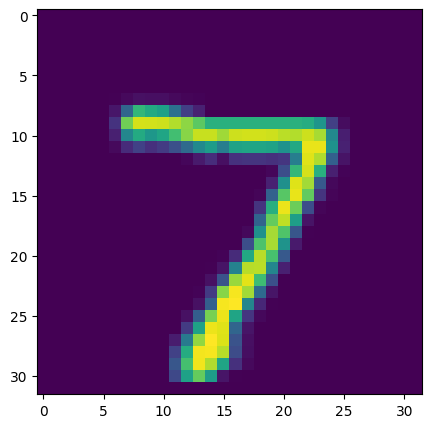

In [ ]:
print_image(test[0][0])

In [ ]:
model = DDPM(
    n_timesteps=TIME_STEPS,
    in_channels=1,
    out_channels=1,
    channel_scale=256,
    train_set=train,
    test_set=test,
    train_batch_size=BATCH_SIZE,
    test_batch_size=8
)

In [ ]:
print("model size : ", sum(p.numel() for p in model.g.parameters() if p.requires_grad))

model size :  208482049


In [ ]:
history = model.train(n_epoch=30)

EPOCH 1:


100%|██████████| 59/59 [00:59<00:00,  1.02s/it]


# epoch 1 avg_loss: 0.012556821076294123
EPOCH 2:


100%|██████████| 59/59 [00:59<00:00,  1.01s/it]


# epoch 2 avg_loss: 0.012230187054660361
EPOCH 3:


100%|██████████| 59/59 [00:59<00:00,  1.01s/it]


# epoch 3 avg_loss: 0.012458994321651378
EPOCH 4:


100%|██████████| 59/59 [00:59<00:00,  1.01s/it]


# epoch 4 avg_loss: 0.01280535673880476
EPOCH 5:


100%|██████████| 59/59 [00:59<00:00,  1.01s/it]


# epoch 5 avg_loss: 0.013095741870544724
EPOCH 6:


100%|██████████| 59/59 [00:59<00:00,  1.01s/it]


# epoch 6 avg_loss: 0.012307483781823668
EPOCH 7:


100%|██████████| 59/59 [00:59<00:00,  1.01s/it]


# epoch 7 avg_loss: 0.012259867894700018
EPOCH 8:


100%|██████████| 59/59 [00:59<00:00,  1.01s/it]


# epoch 8 avg_loss: 0.012114099447883792
EPOCH 9:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 9 avg_loss: 0.01185297399317309
EPOCH 10:


100%|██████████| 59/59 [00:59<00:00,  1.02s/it]


# epoch 10 avg_loss: 0.01190931408397727
EPOCH 11:


100%|██████████| 59/59 [00:59<00:00,  1.02s/it]


# epoch 11 avg_loss: 0.011870924699104439
EPOCH 12:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 12 avg_loss: 0.011641847711624735
EPOCH 13:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 13 avg_loss: 0.011741347768801754
EPOCH 14:


100%|██████████| 59/59 [00:59<00:00,  1.02s/it]


# epoch 14 avg_loss: 0.011959217094137506
EPOCH 15:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 15 avg_loss: 0.011554686510461872
EPOCH 16:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 16 avg_loss: 0.011532191281854096
EPOCH 17:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 17 avg_loss: 0.011281790401218302
EPOCH 18:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 18 avg_loss: 0.01143778150238223
EPOCH 19:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 19 avg_loss: 0.01177401070372533
EPOCH 20:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 20 avg_loss: 0.010802210987371913
EPOCH 21:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 21 avg_loss: 0.011157758091971025
EPOCH 22:


100%|██████████| 59/59 [00:59<00:00,  1.02s/it]


# epoch 22 avg_loss: 0.011068512385679503
EPOCH 23:


100%|██████████| 59/59 [00:59<00:00,  1.01s/it]


# epoch 23 avg_loss: 0.011111099462387926
EPOCH 24:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 24 avg_loss: 0.011262810978470213
EPOCH 25:


100%|██████████| 59/59 [01:01<00:00,  1.04s/it]


# epoch 25 avg_loss: 0.01112759010708433
EPOCH 26:


100%|██████████| 59/59 [00:59<00:00,  1.01s/it]


# epoch 26 avg_loss: 0.010844329387833506
EPOCH 27:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 27 avg_loss: 0.010858176702286228
EPOCH 28:


100%|██████████| 59/59 [01:00<00:00,  1.02s/it]


# epoch 28 avg_loss: 0.010913913532838984
EPOCH 29:


100%|██████████| 59/59 [00:59<00:00,  1.02s/it]


# epoch 29 avg_loss: 0.010867295202688646
EPOCH 30:


100%|██████████| 59/59 [00:59<00:00,  1.01s/it]


# epoch 30 avg_loss: 0.01075195186471535


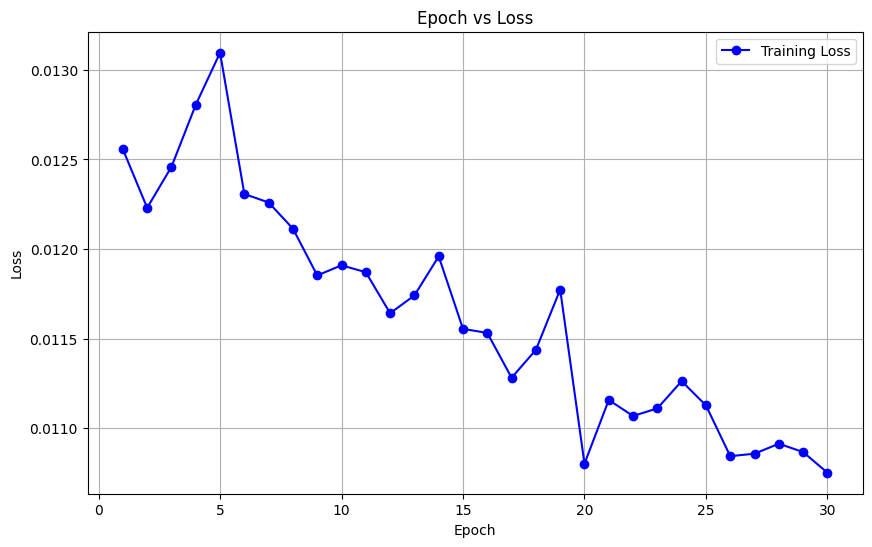

In [ ]:
print_loss(history)

In [ ]:
MODEL_PATH = '/content/drive/My Drive/models/DDPM_MNIST/U256_T1000_E28.pt'
# MODEL_PATH = './U128_T3000_E0.pt'
model.load(MODEL_PATH)

In [ ]:
result_DDPM = model.evaluate(num=5)

  0%|          | 4/1250 [05:02<26:10:21, 75.62s/it]


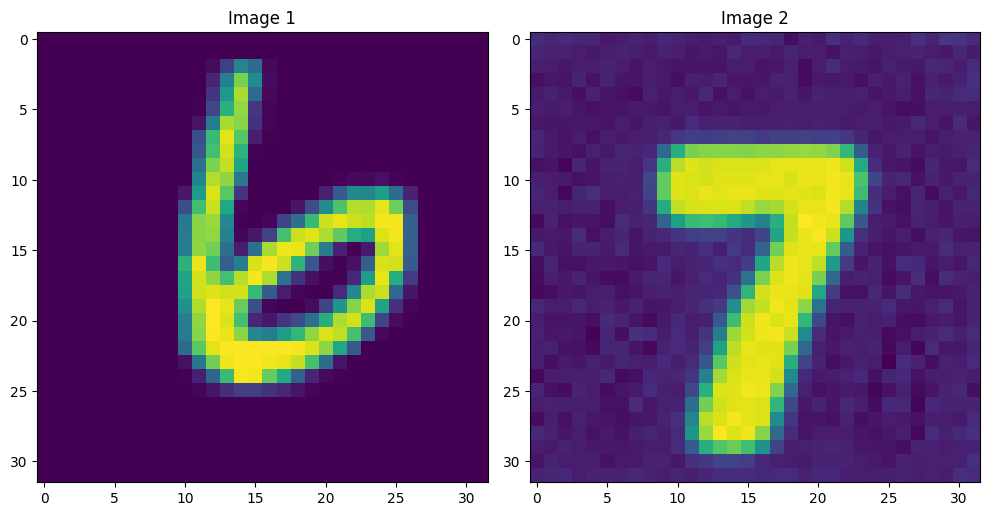

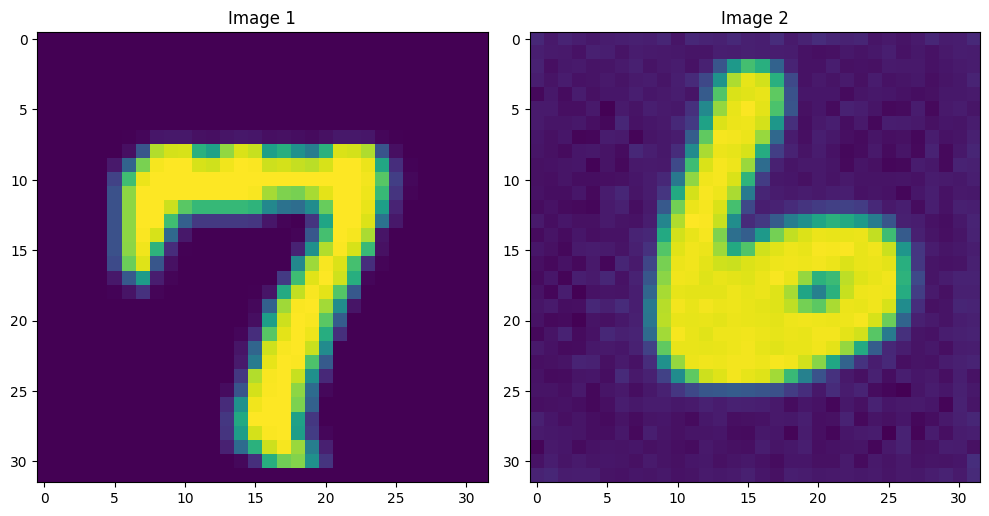

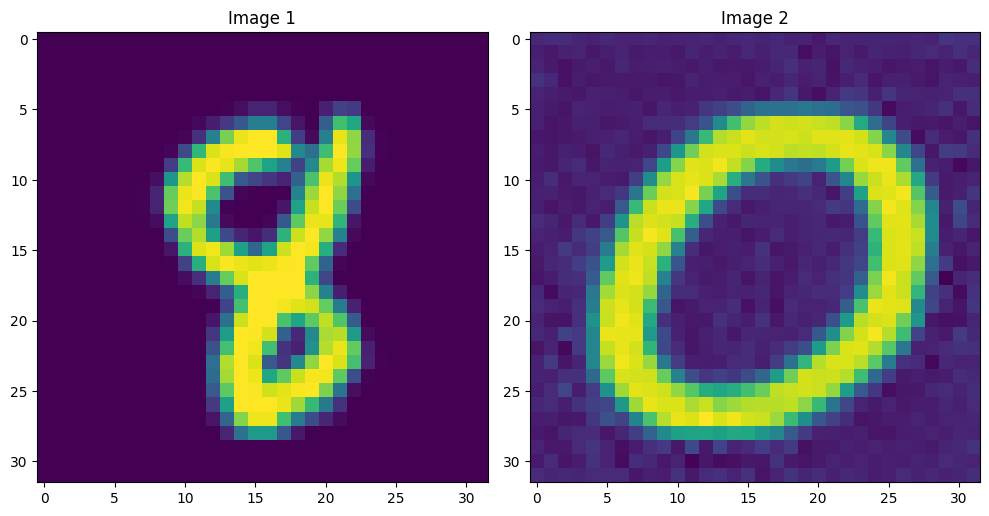

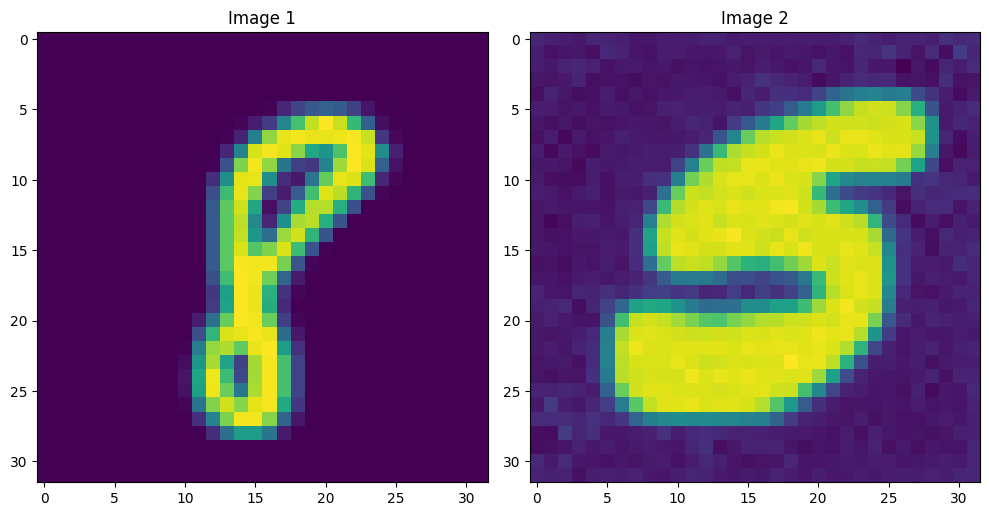

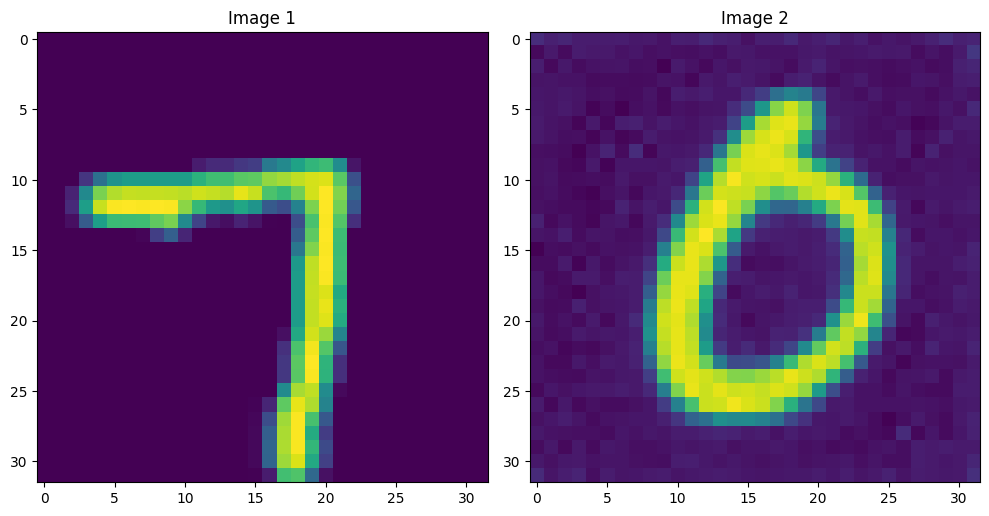

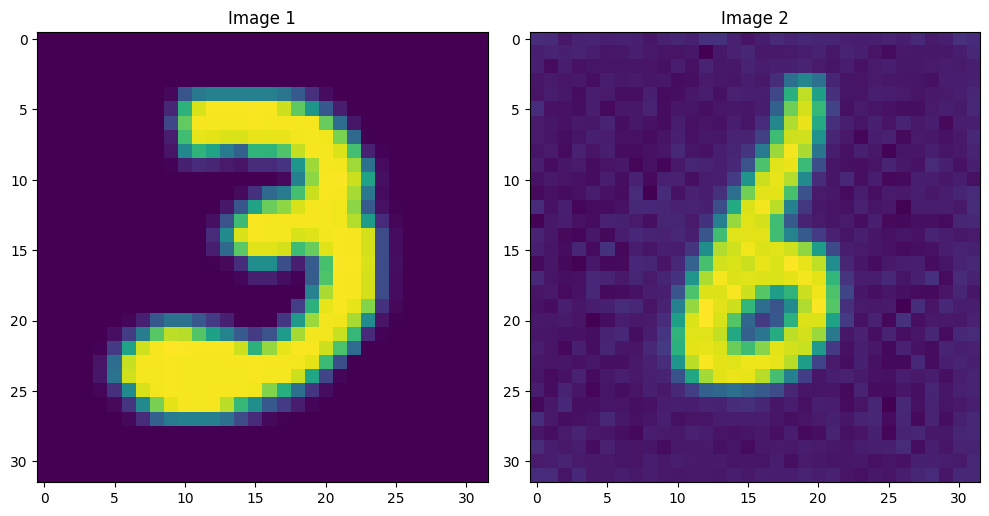

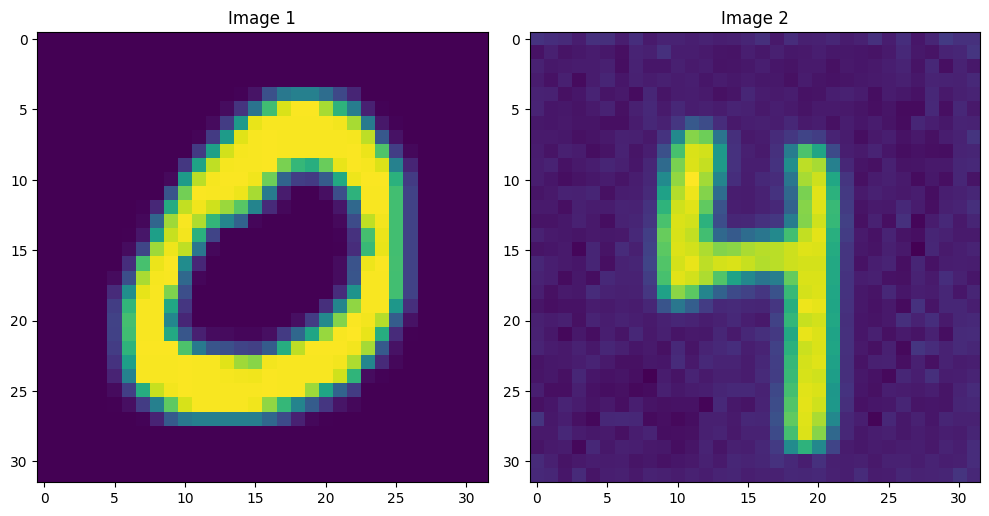

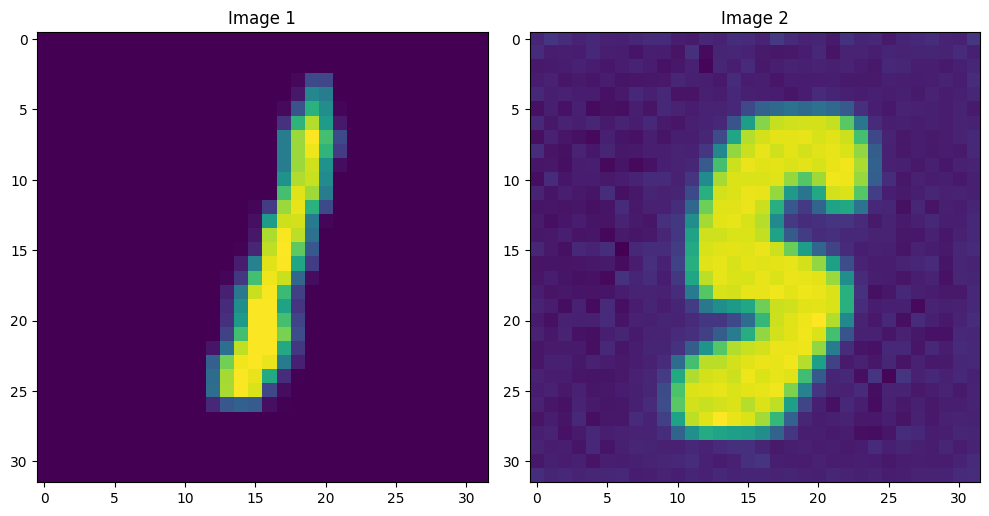

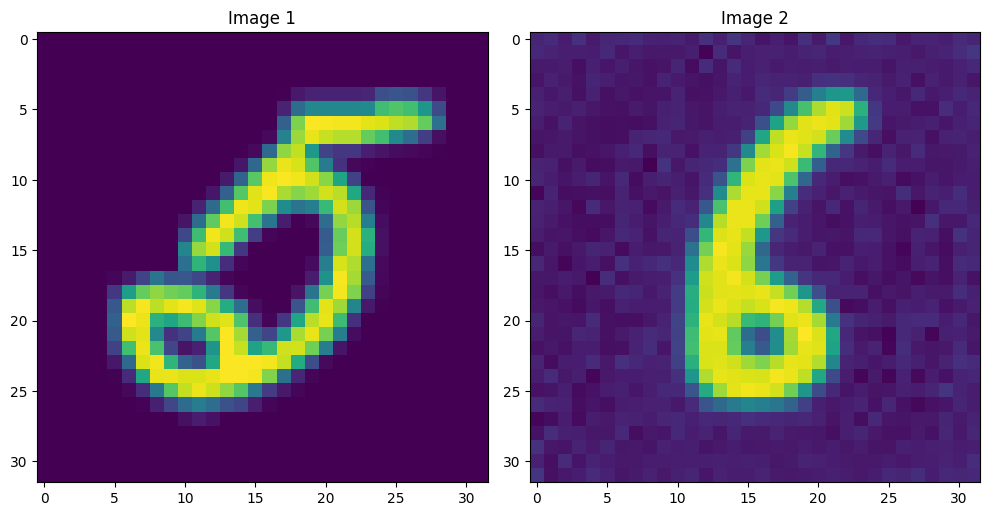

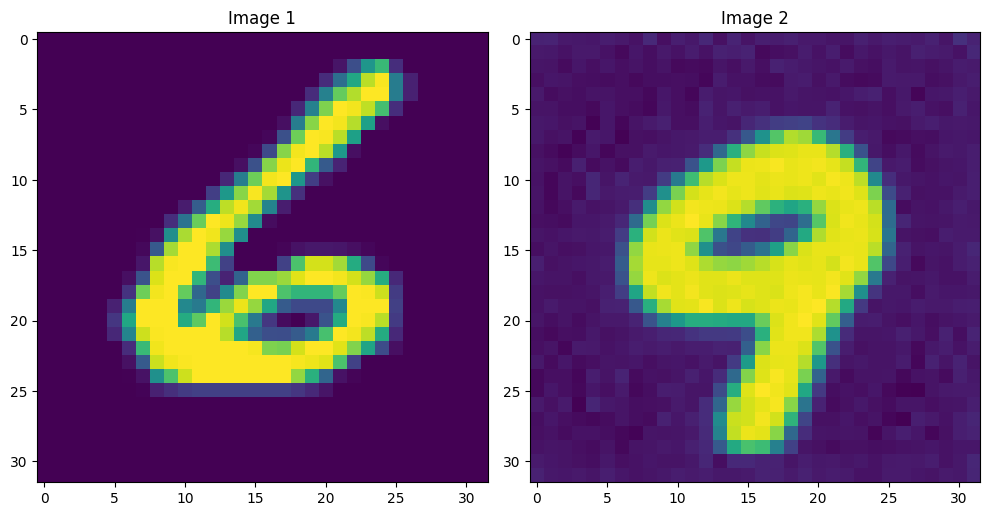

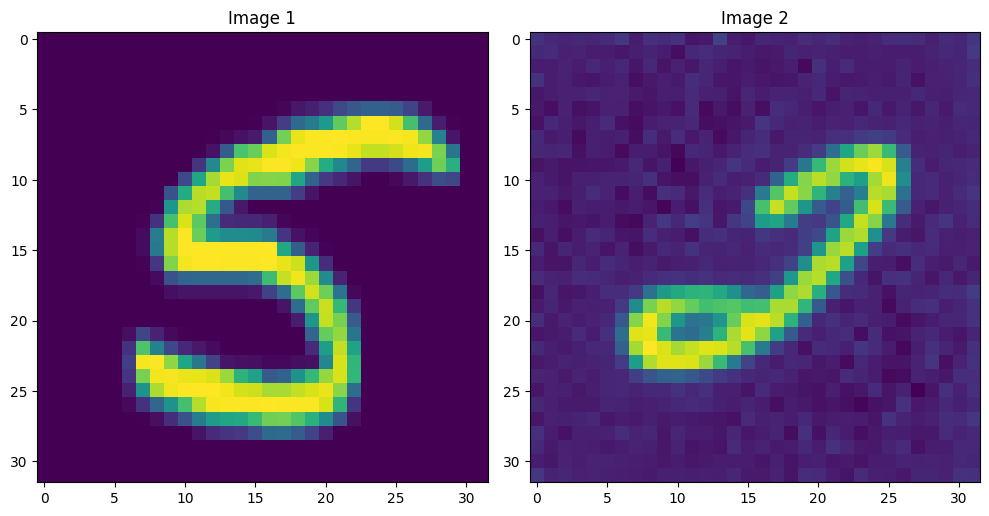

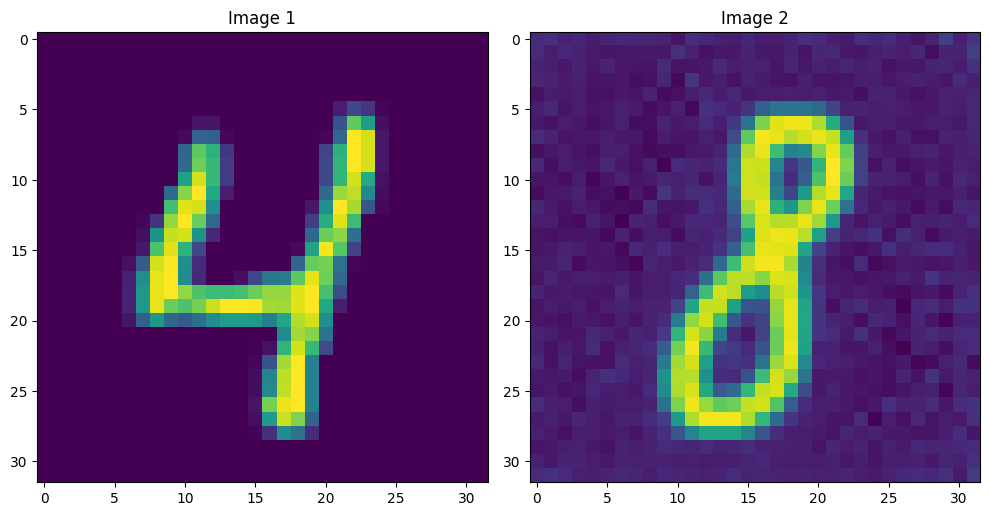

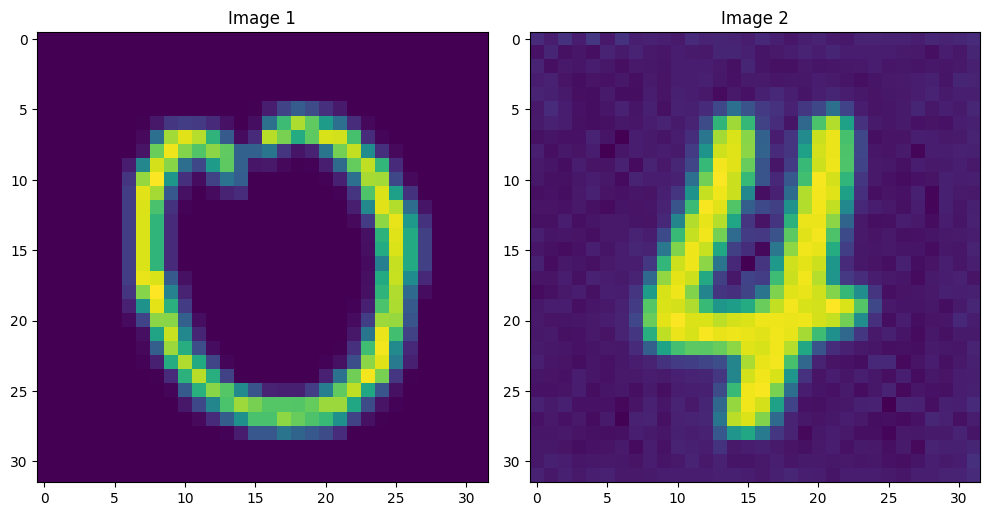

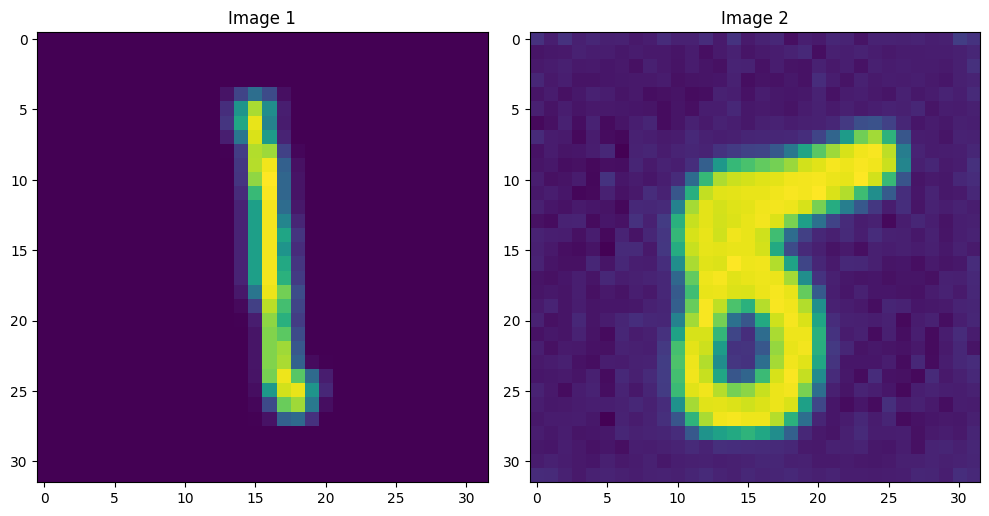

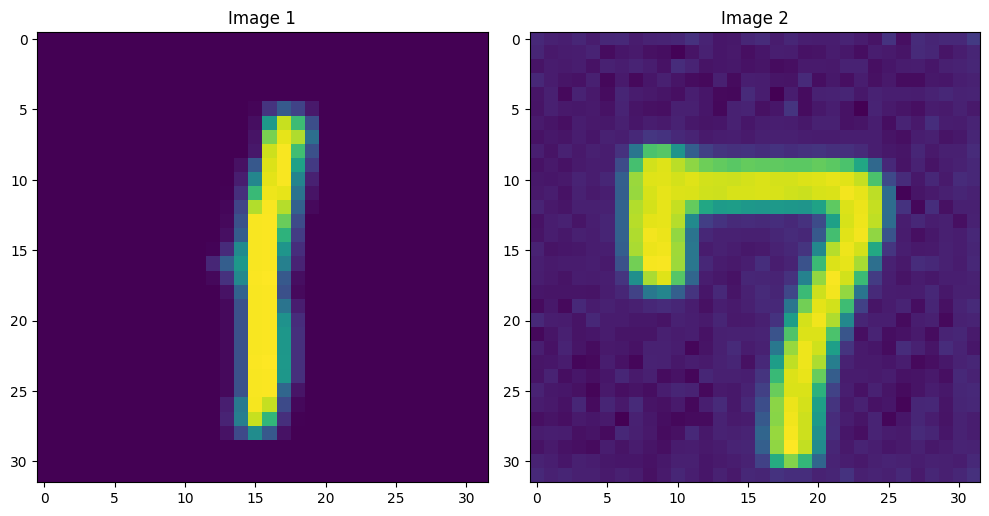

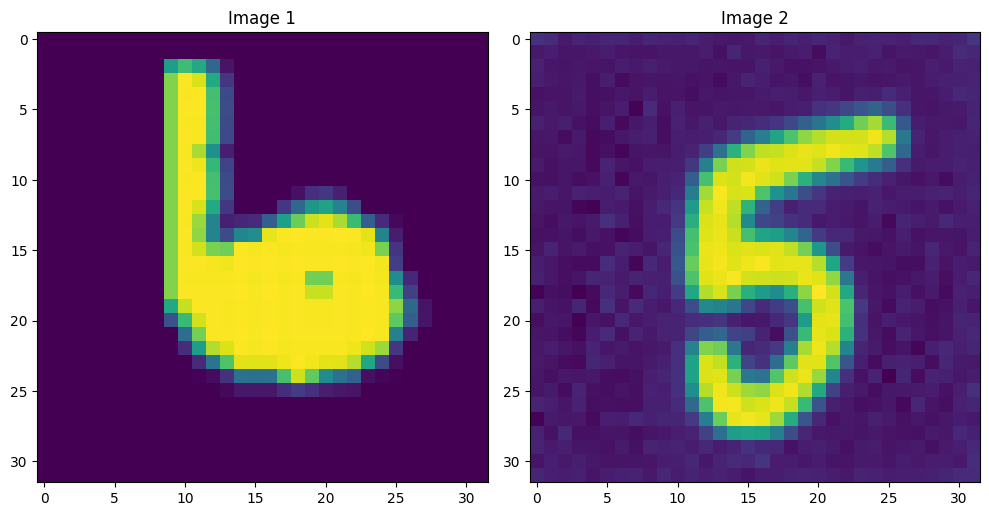

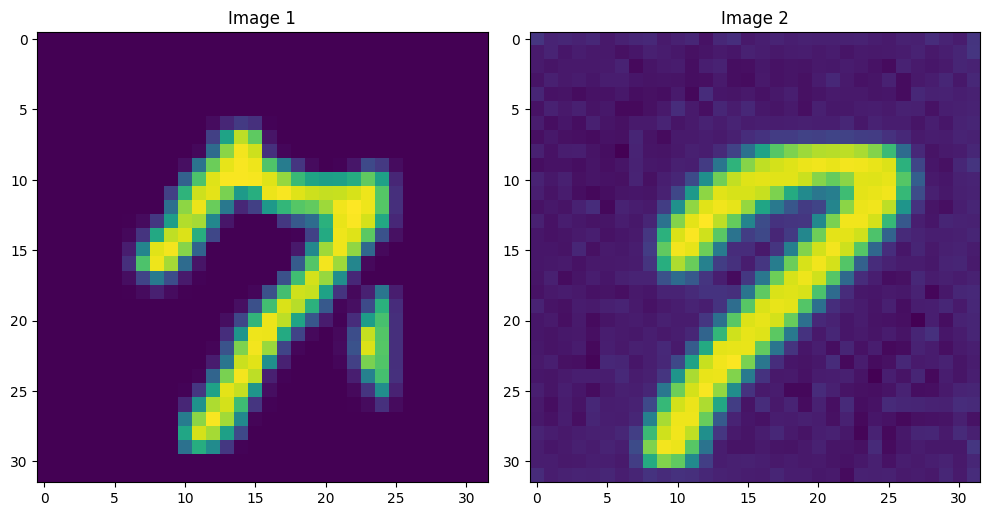

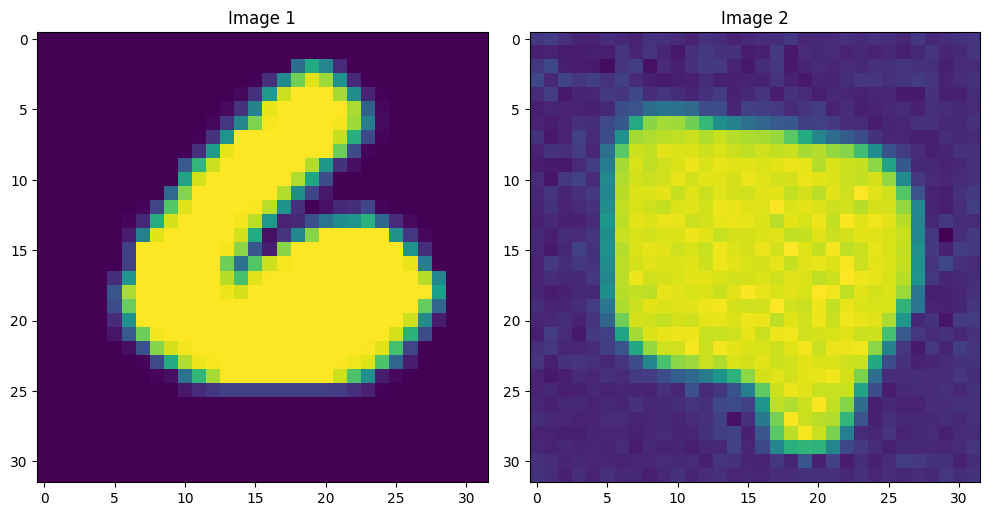

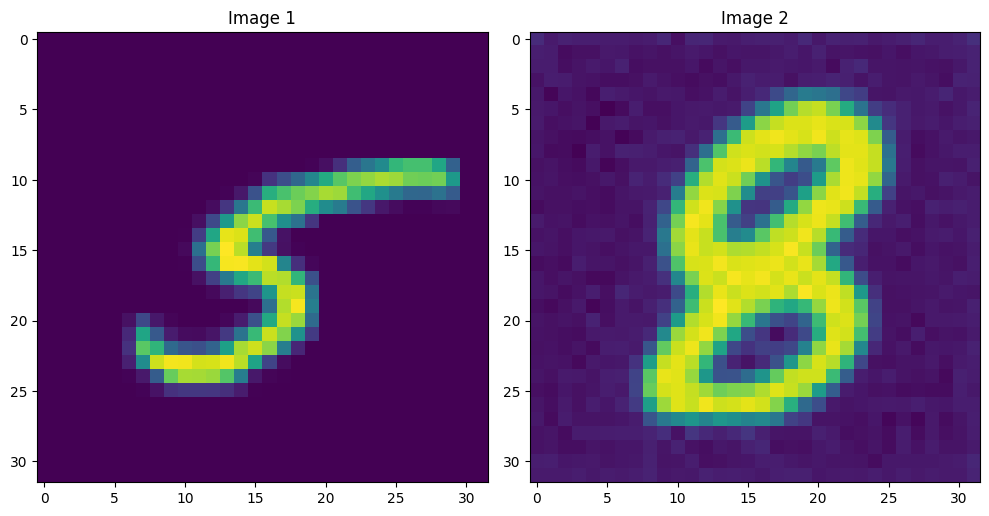

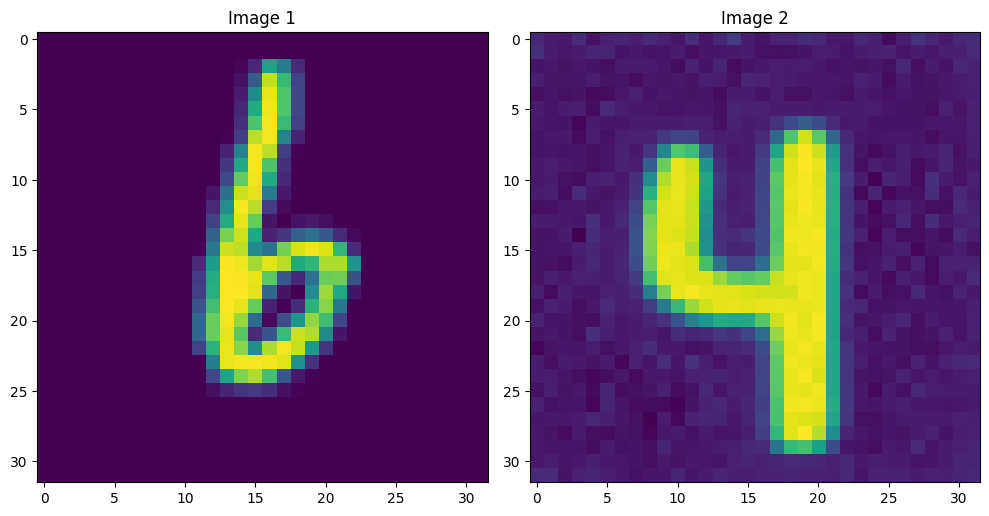

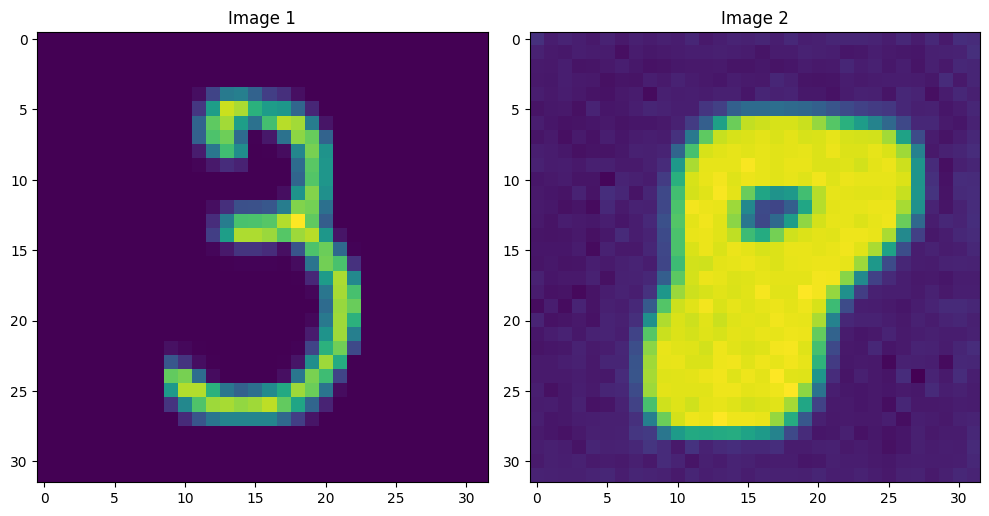

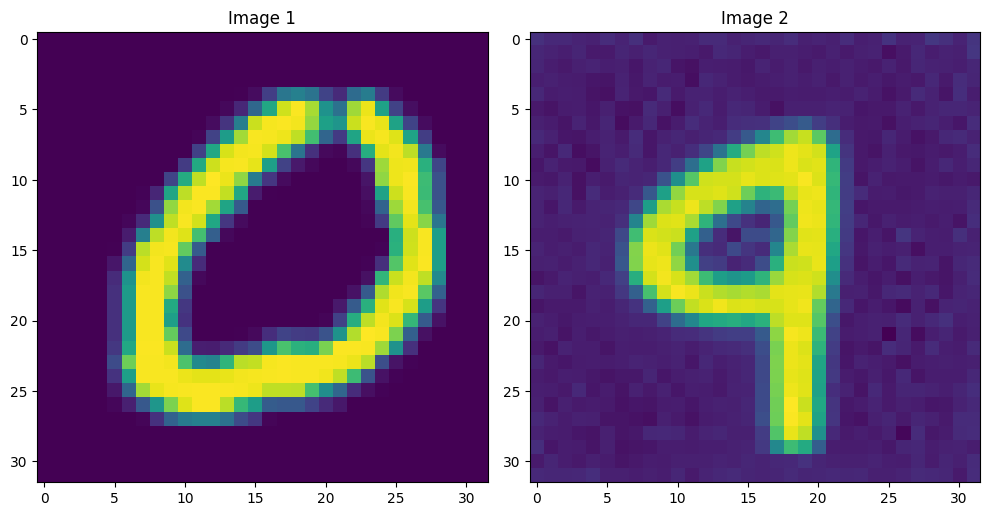

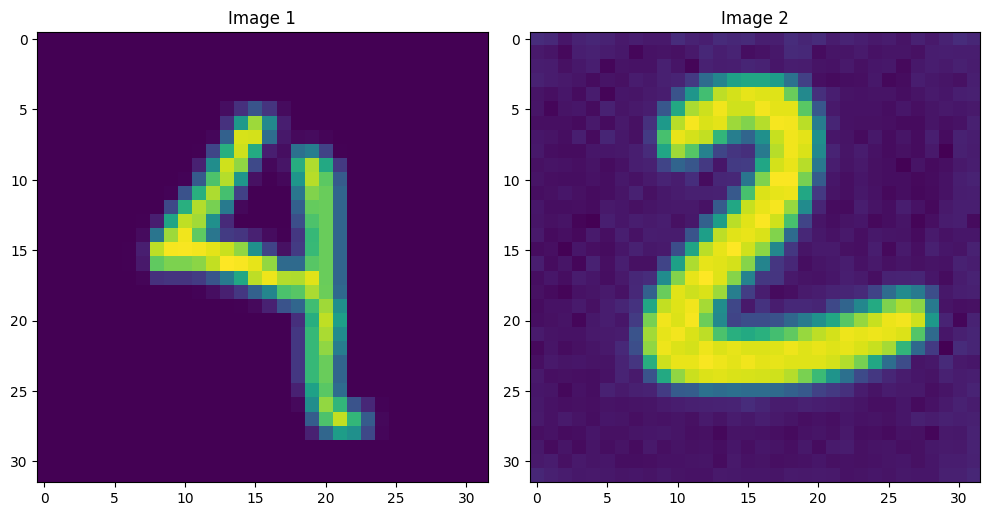

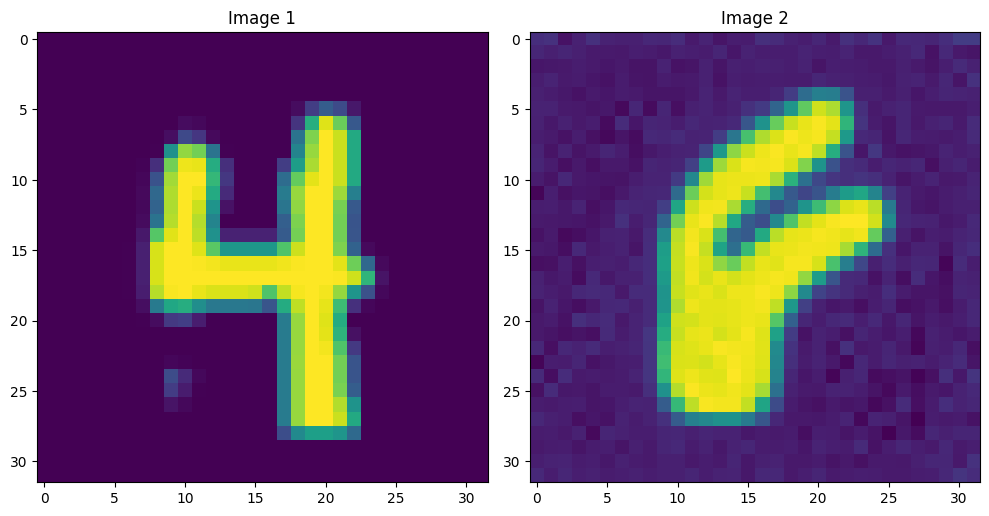

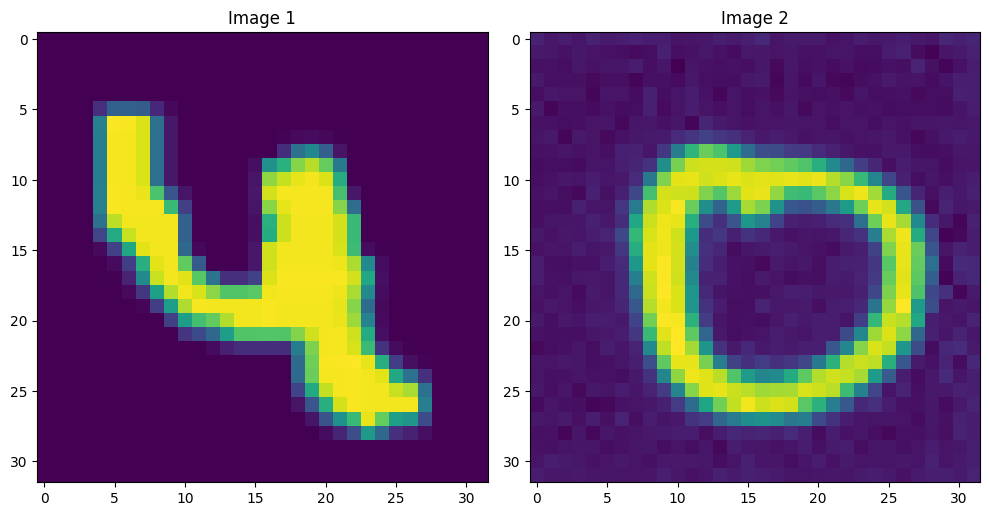

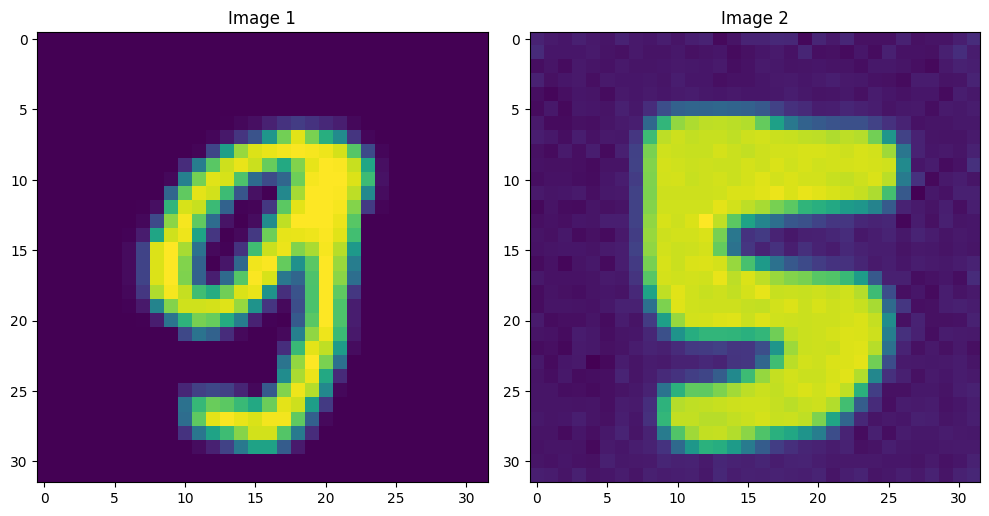

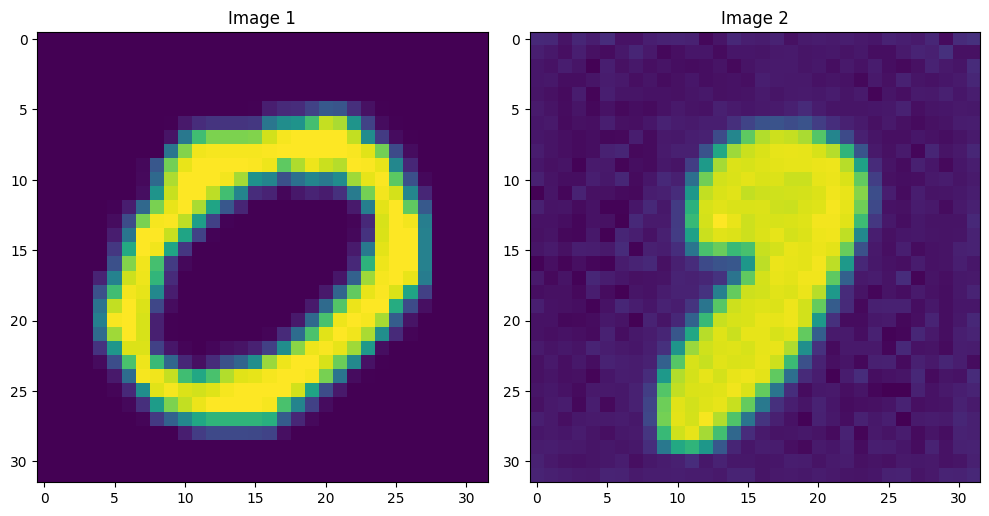

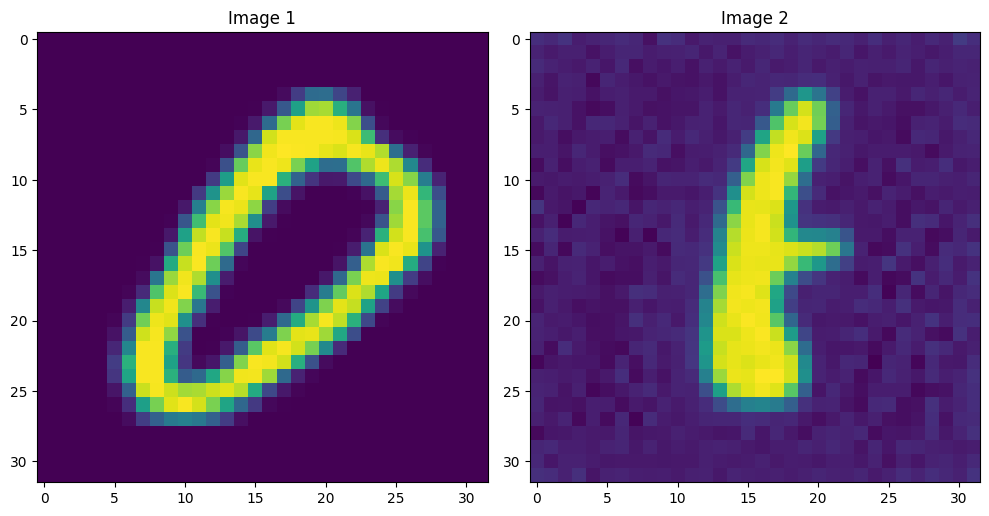

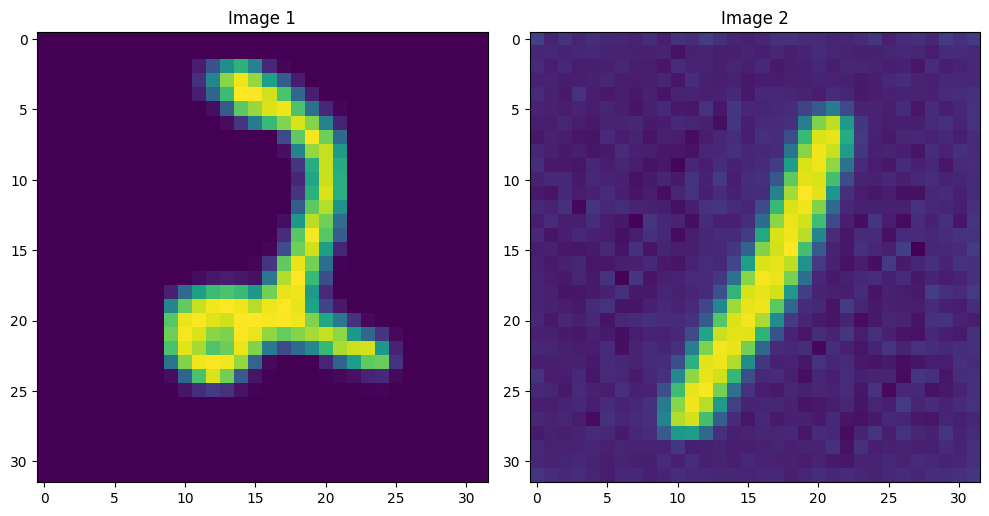

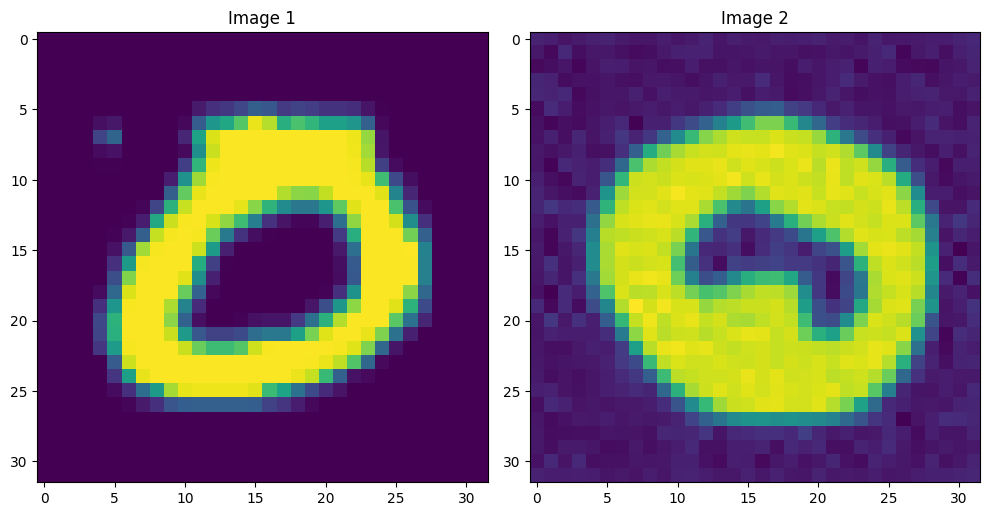

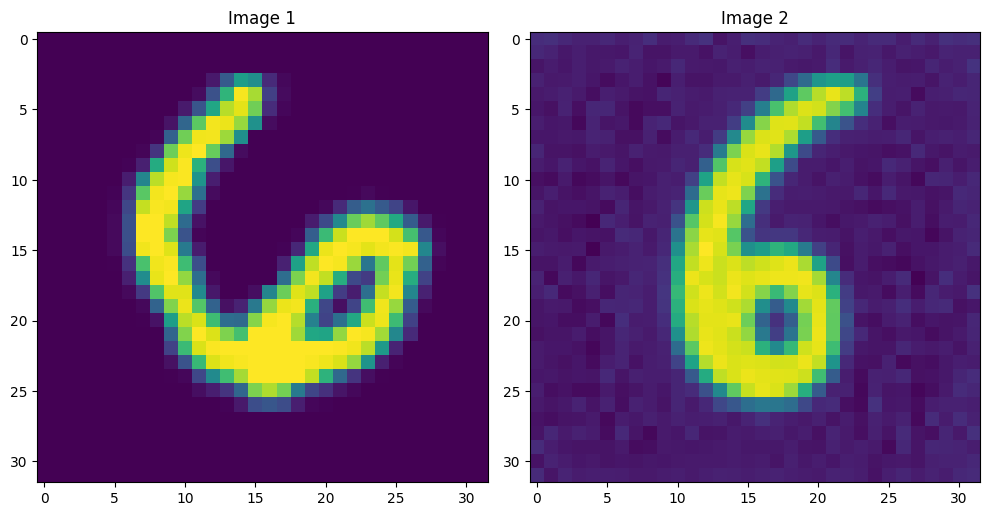

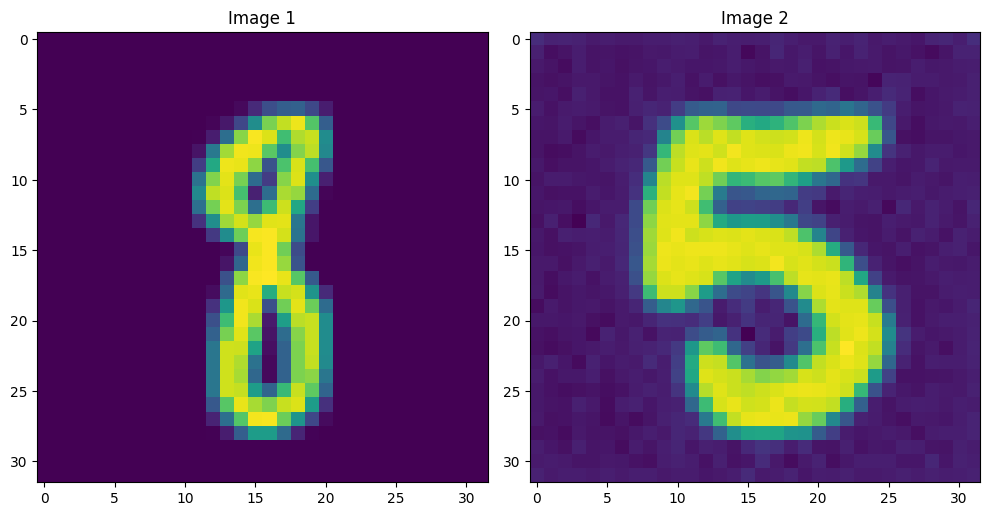

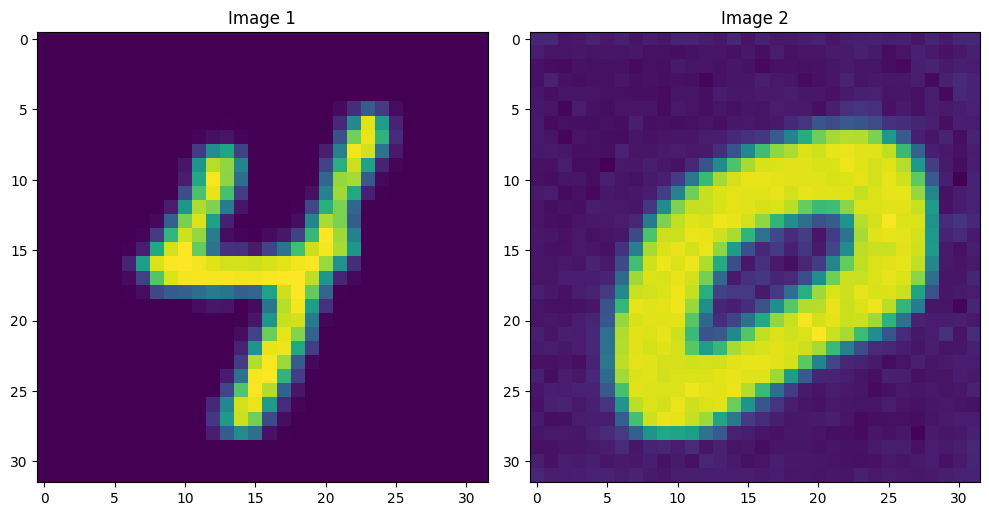

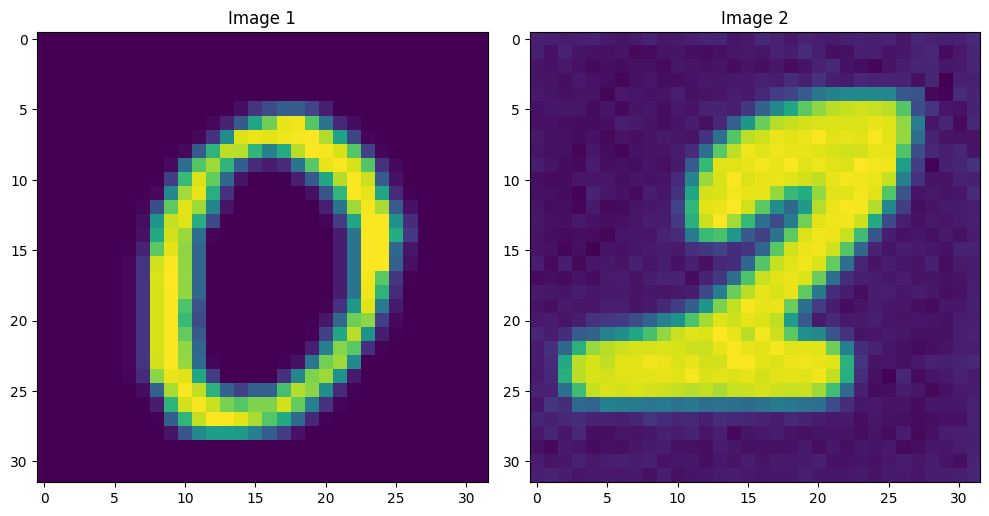

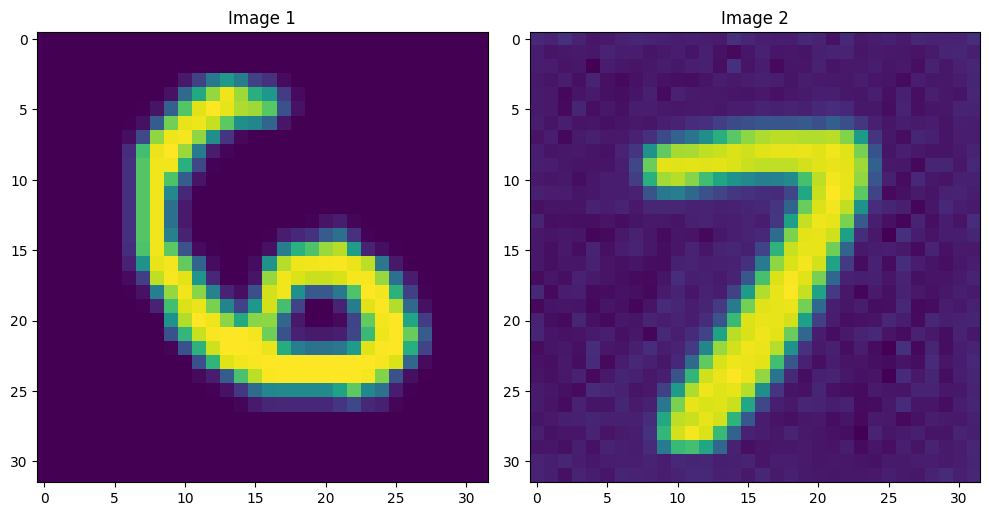

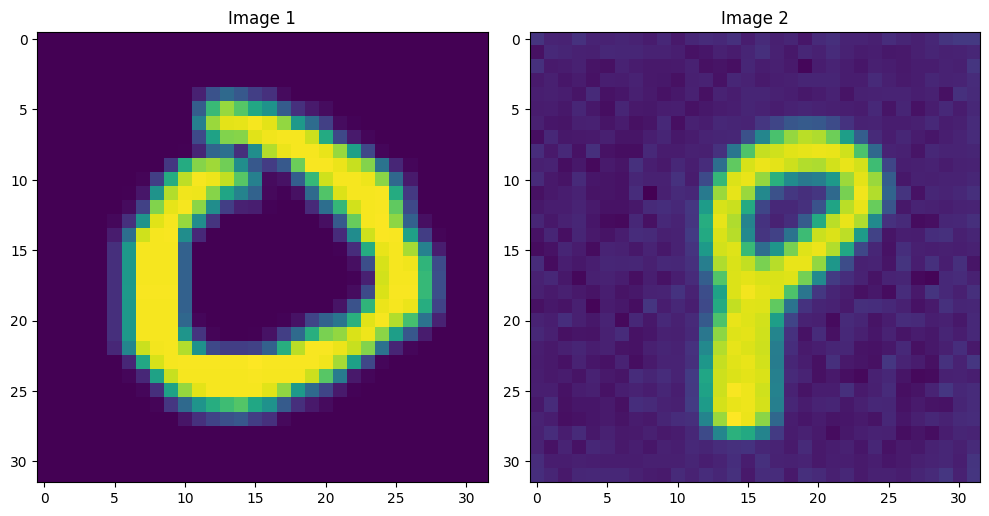

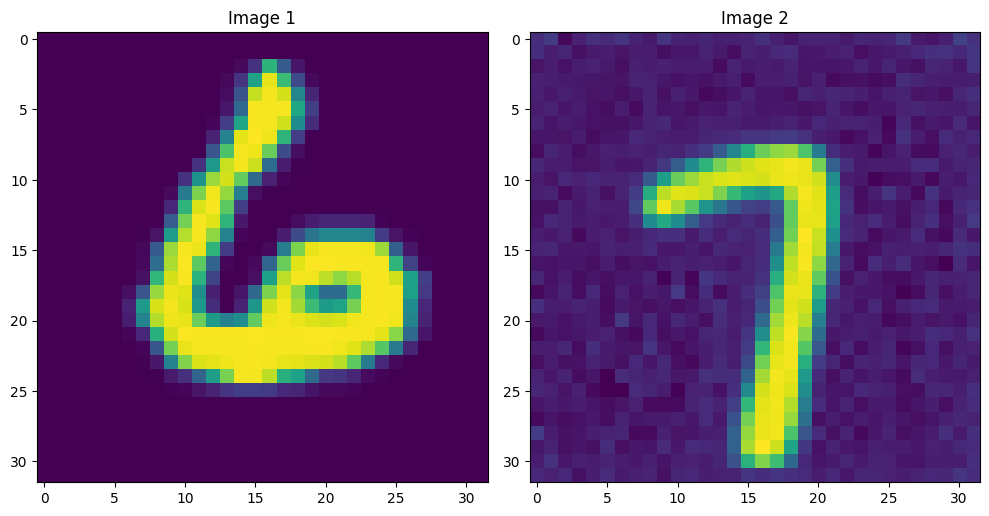

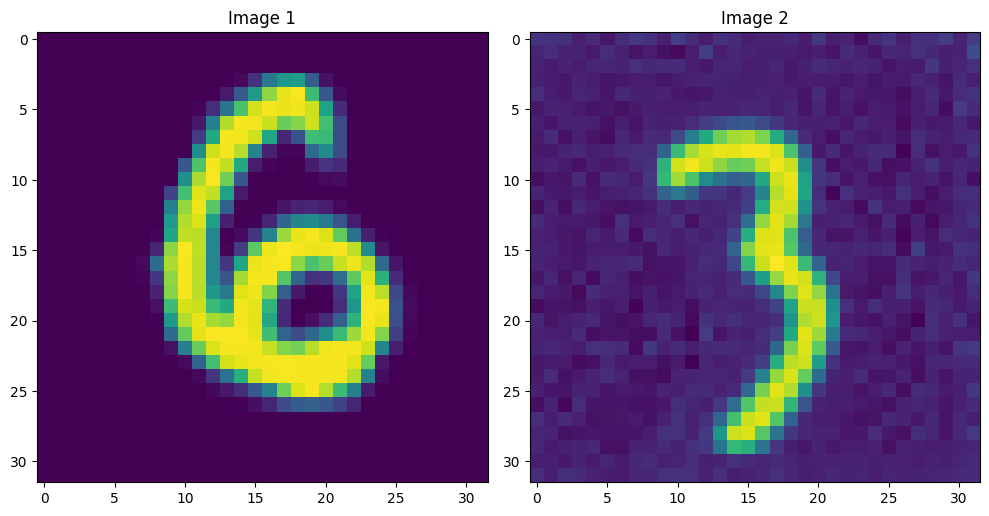

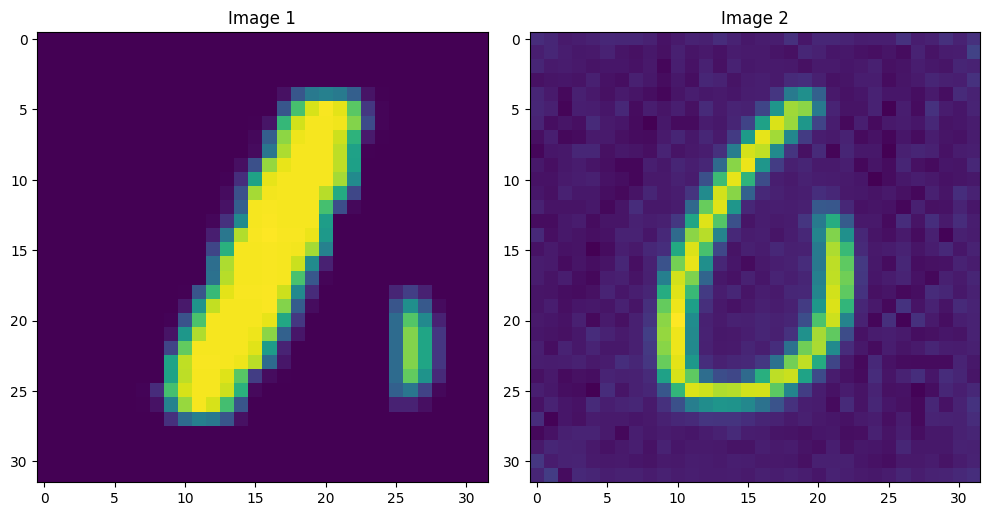

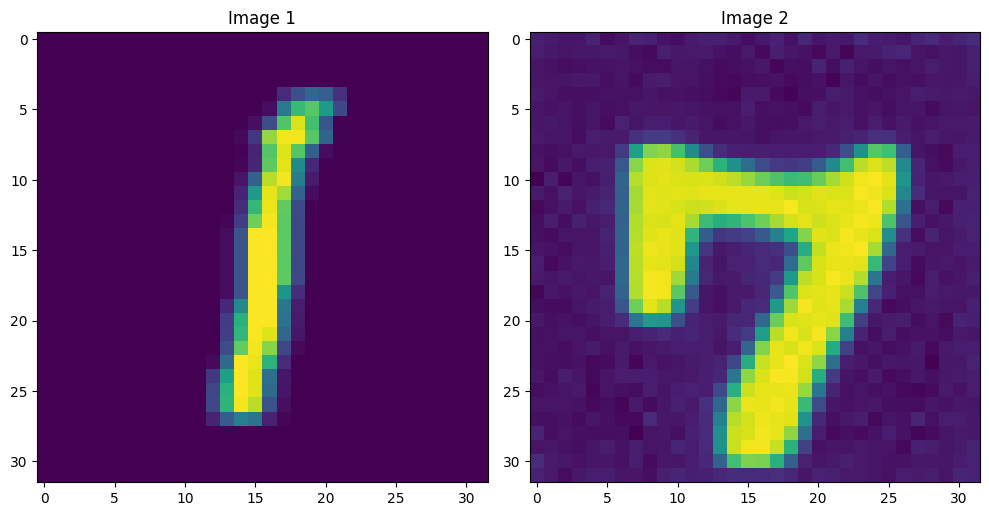

In [ ]:
print_result(result_DDPM)

In [ ]:
result_DDIM = model.evaluate(num=5,
                        sampling_type='DDIM',
                        sampling_time_step=10)
# [num, 3, B, 1, 32, 32]

  0%|          | 4/1250 [00:03<15:56,  1.30it/s]


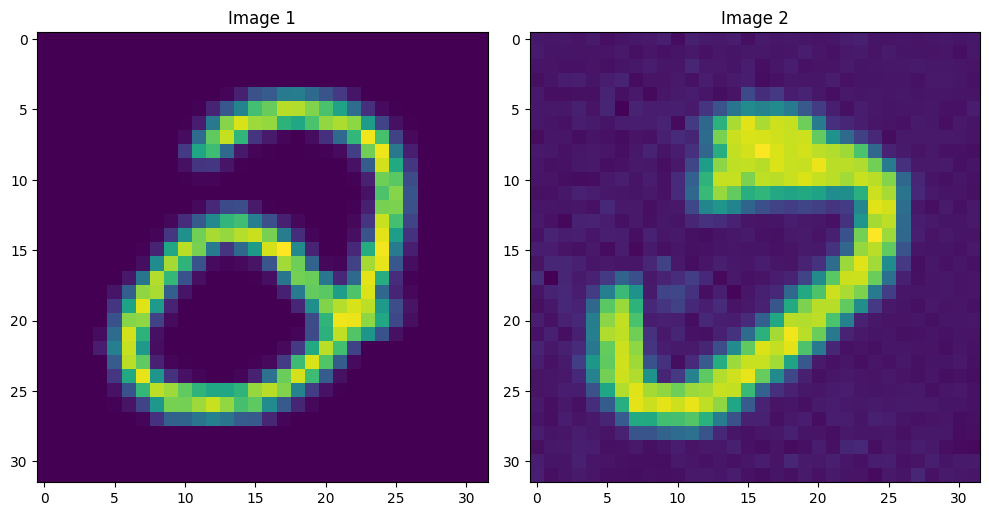

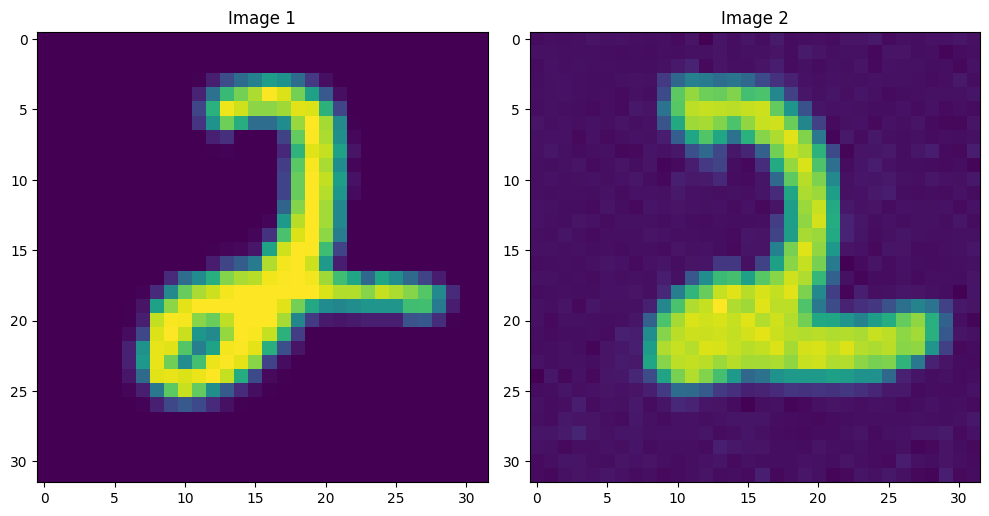

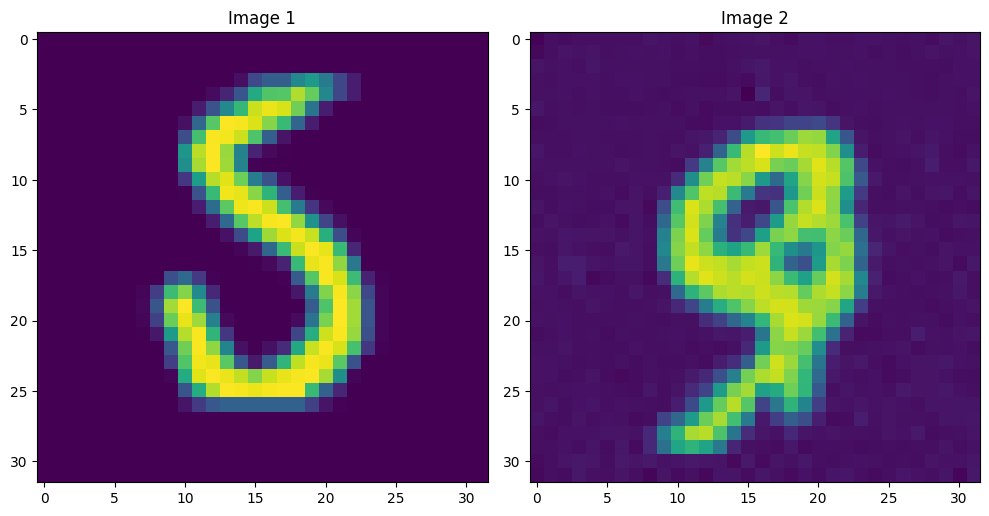

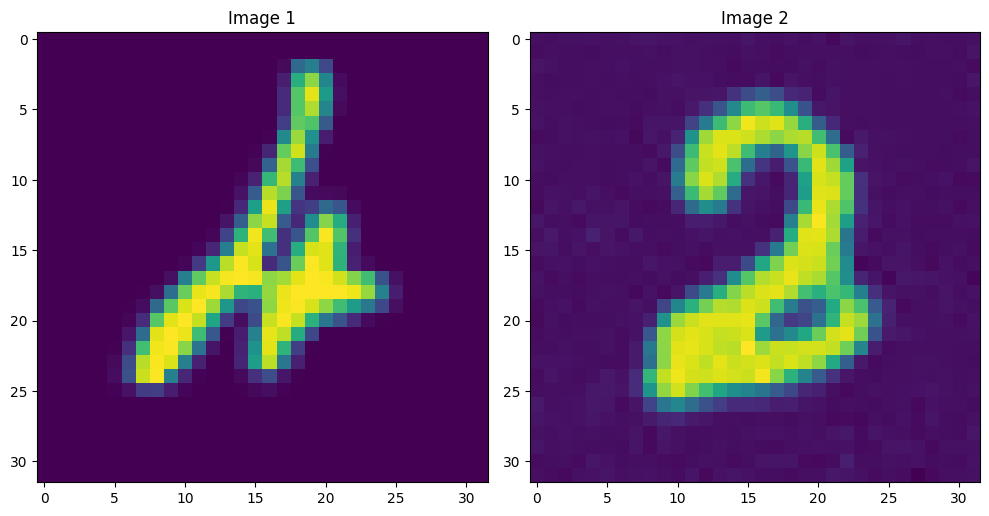

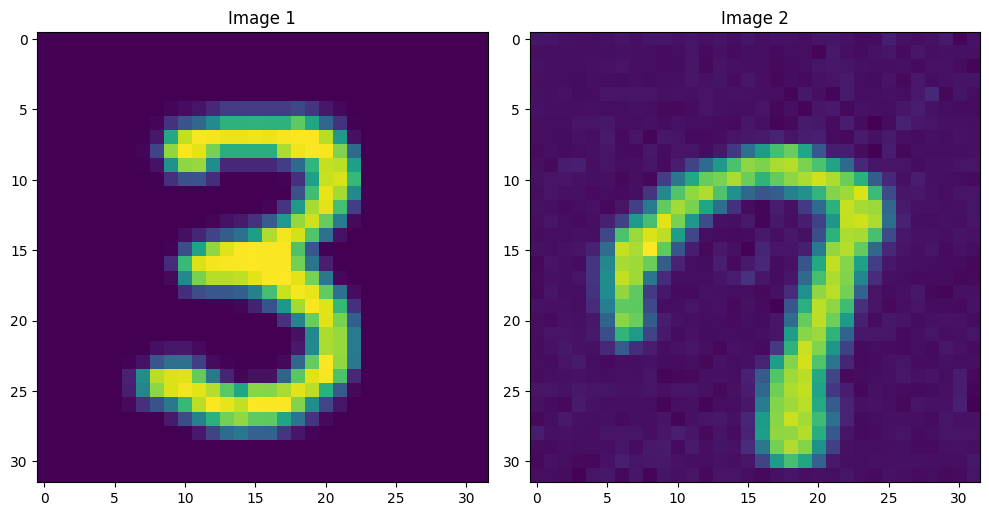

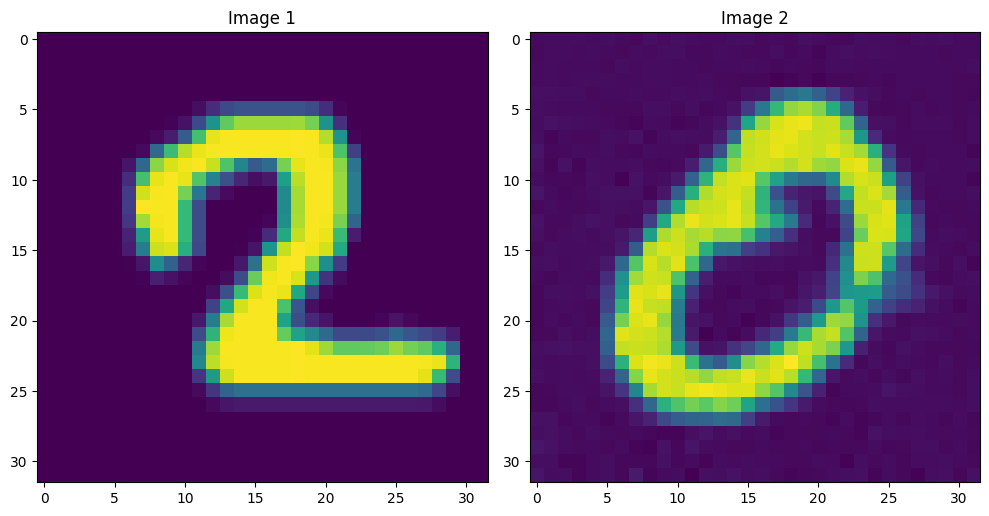

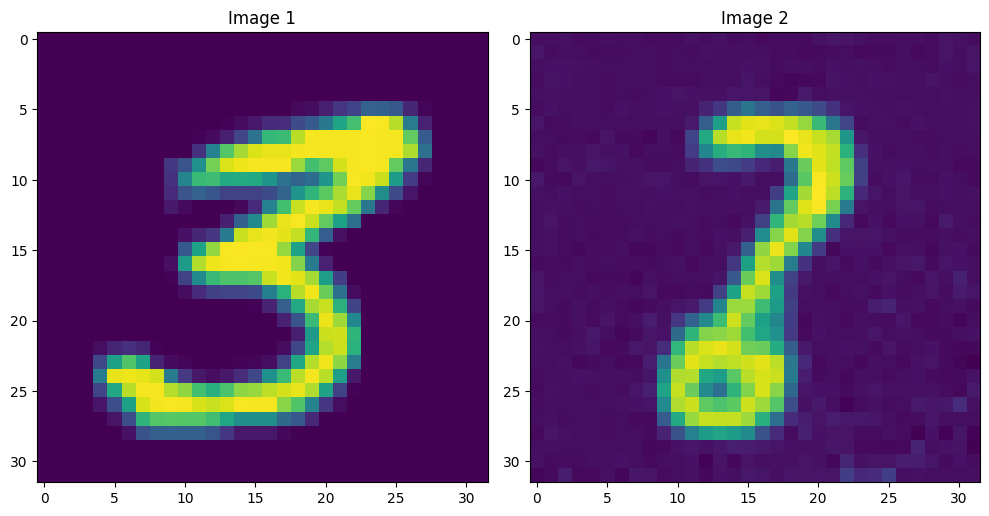

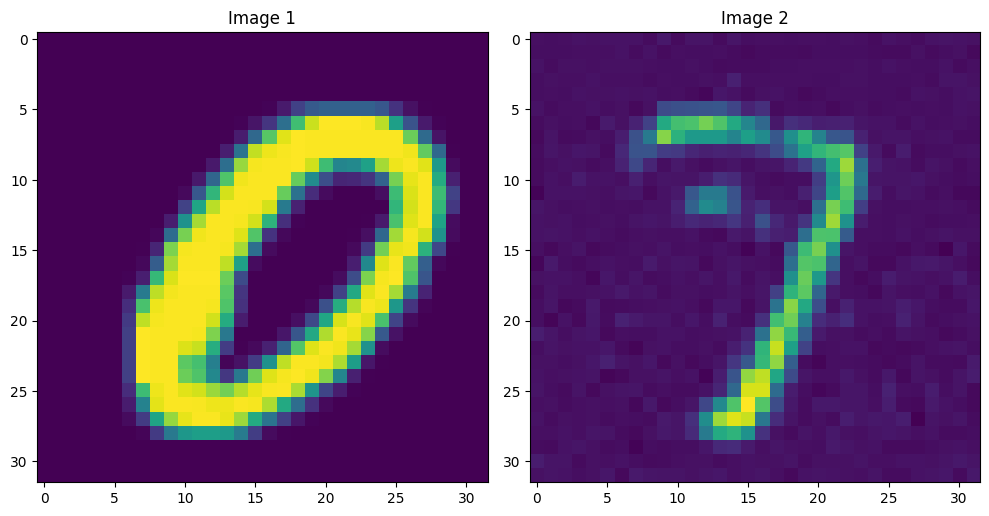

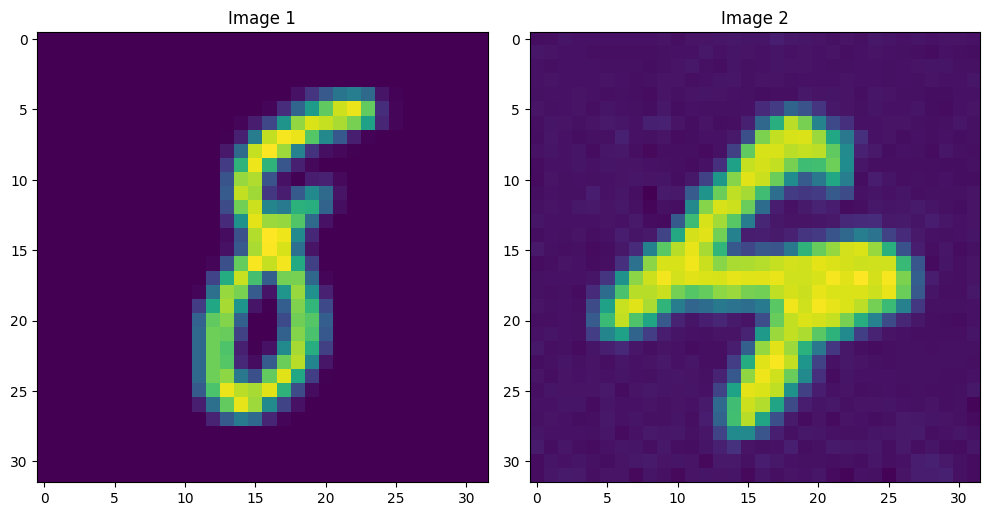

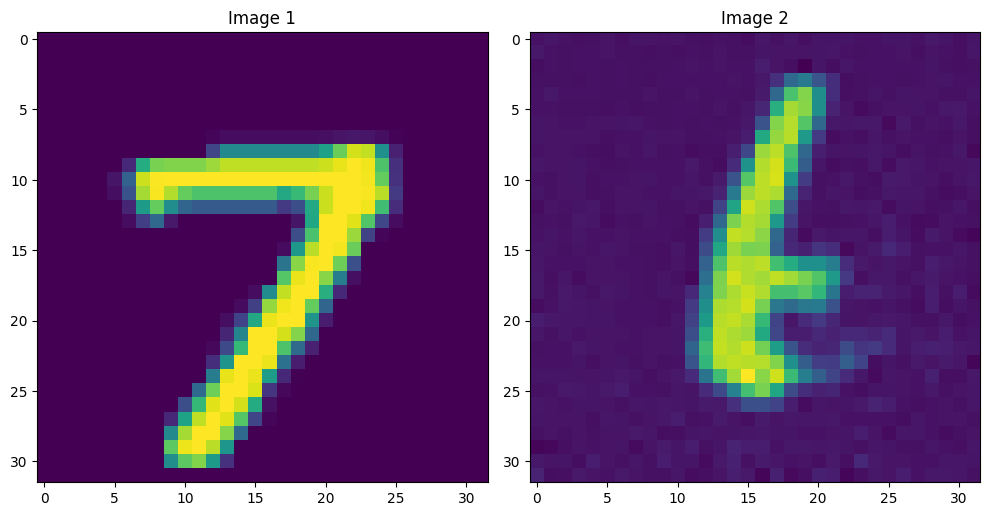

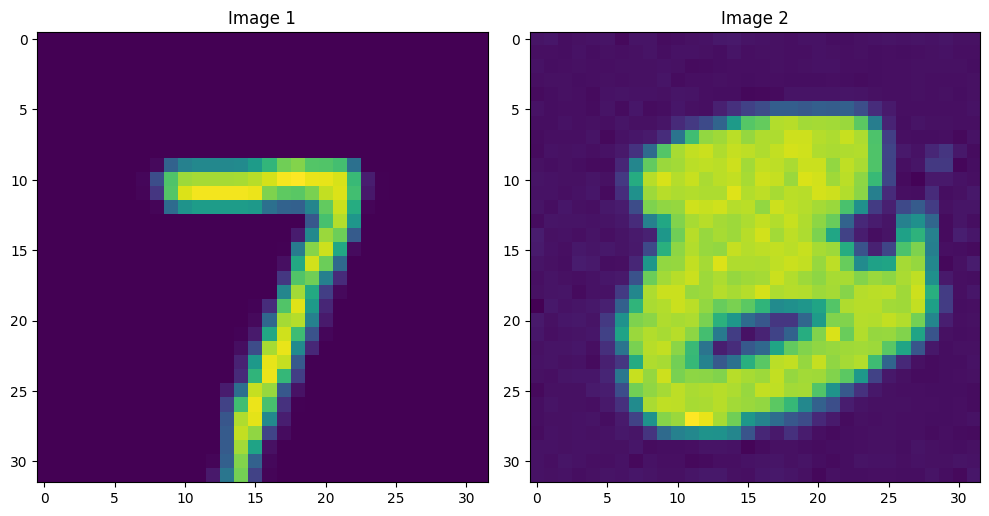

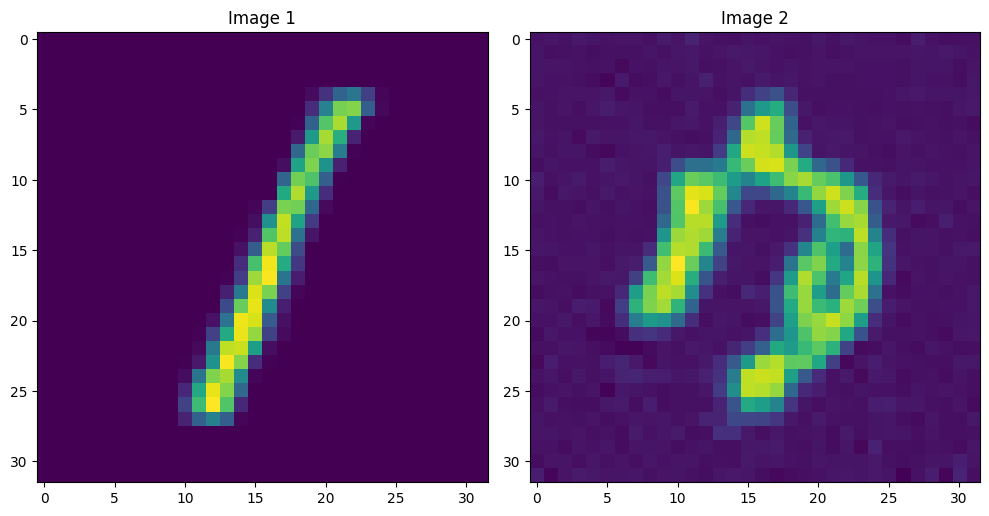

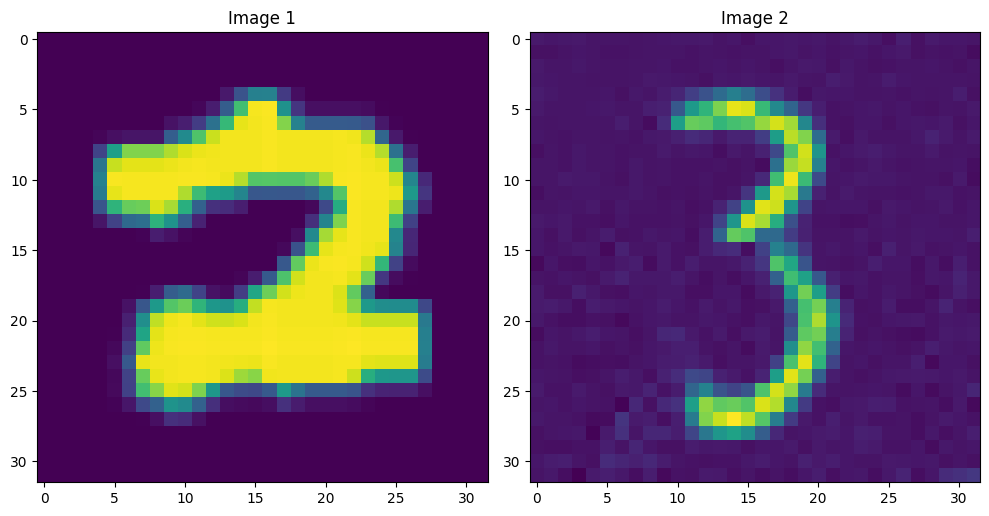

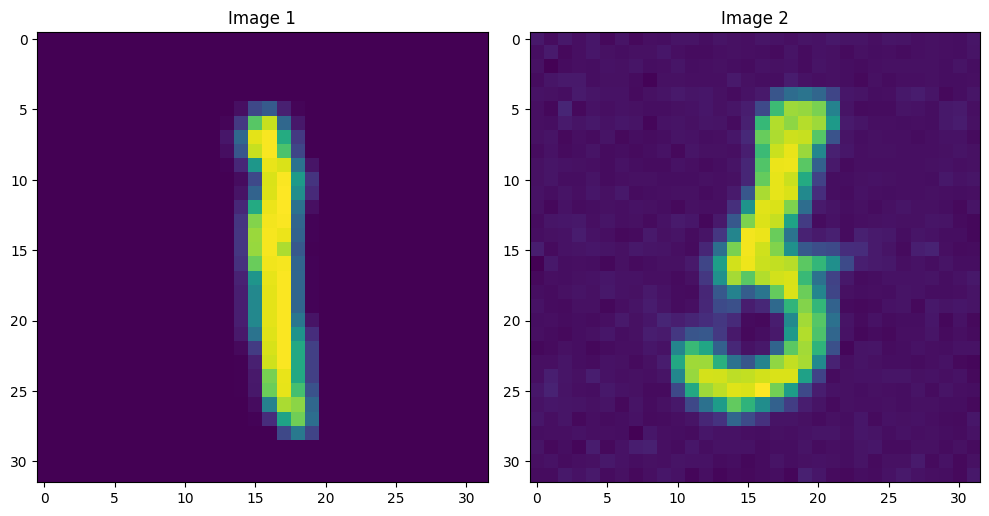

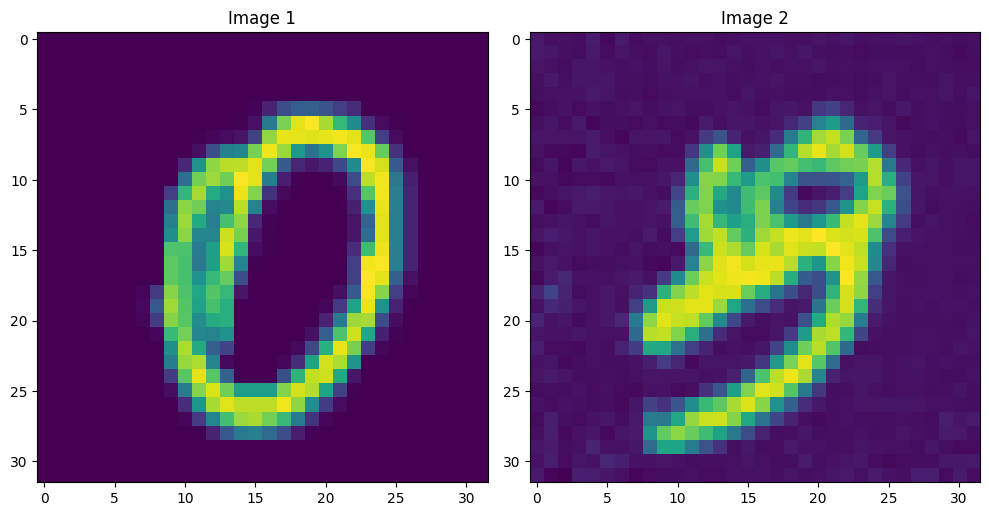

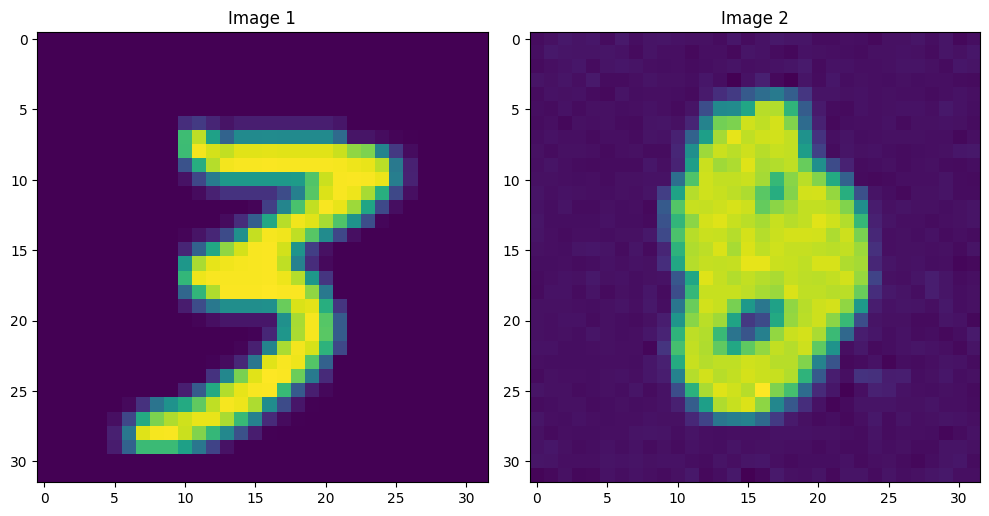

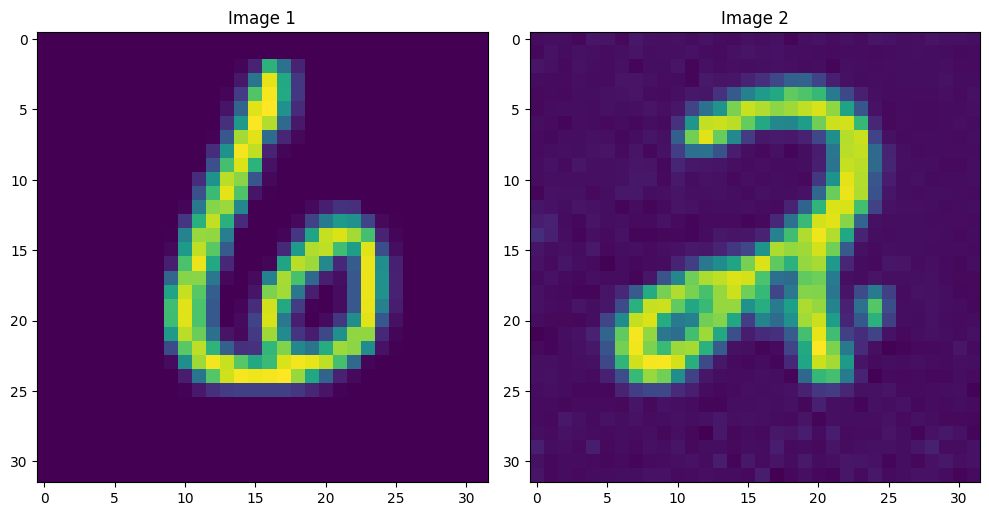

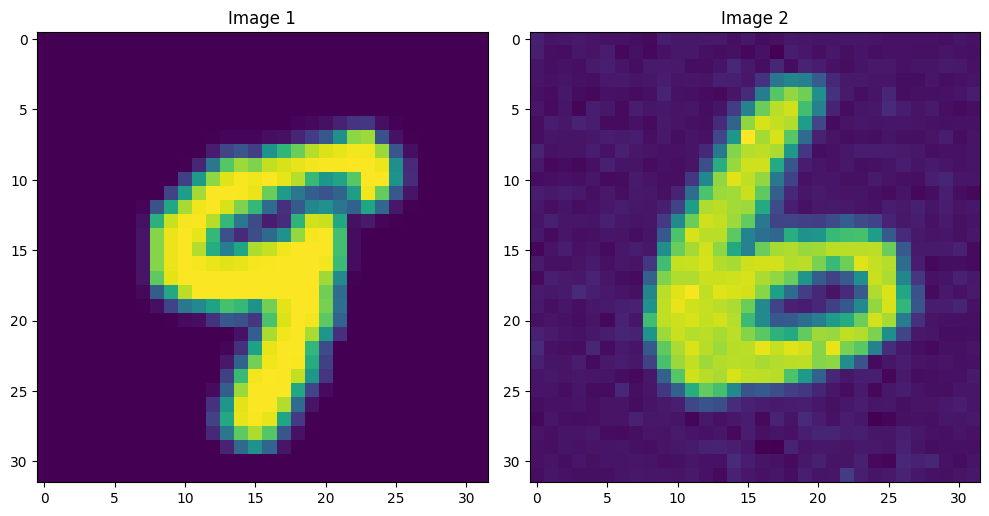

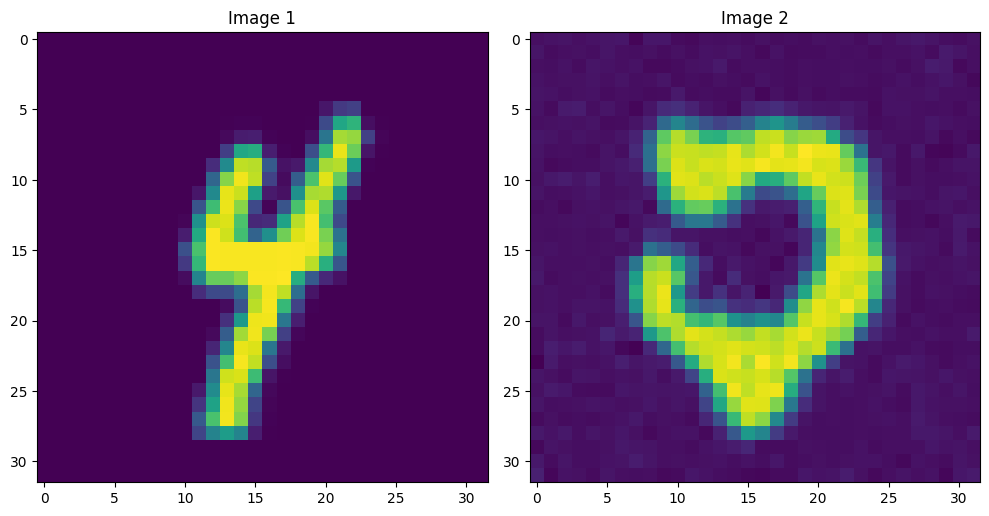

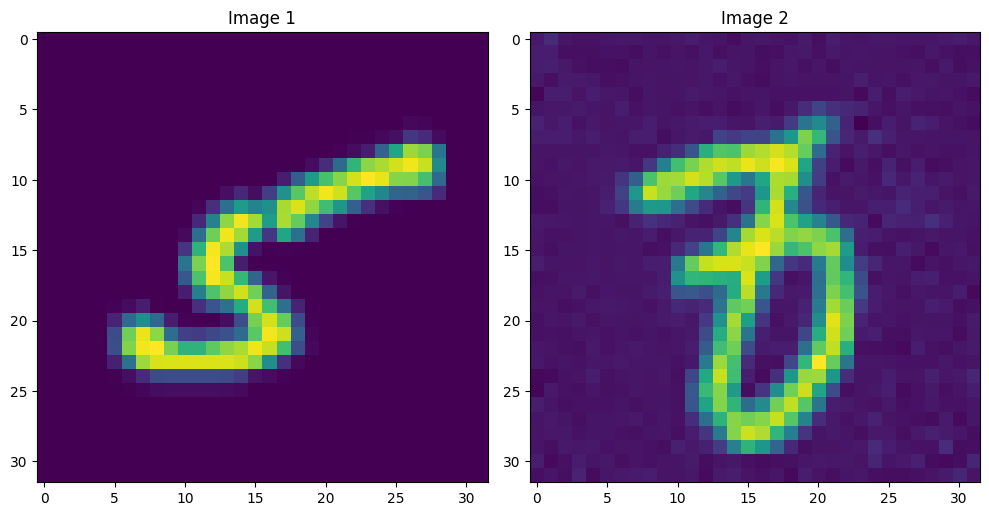

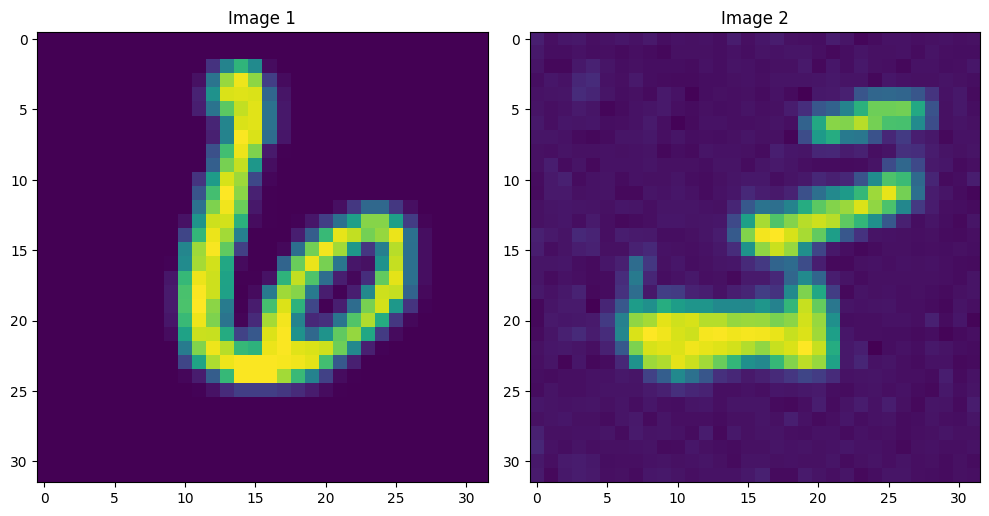

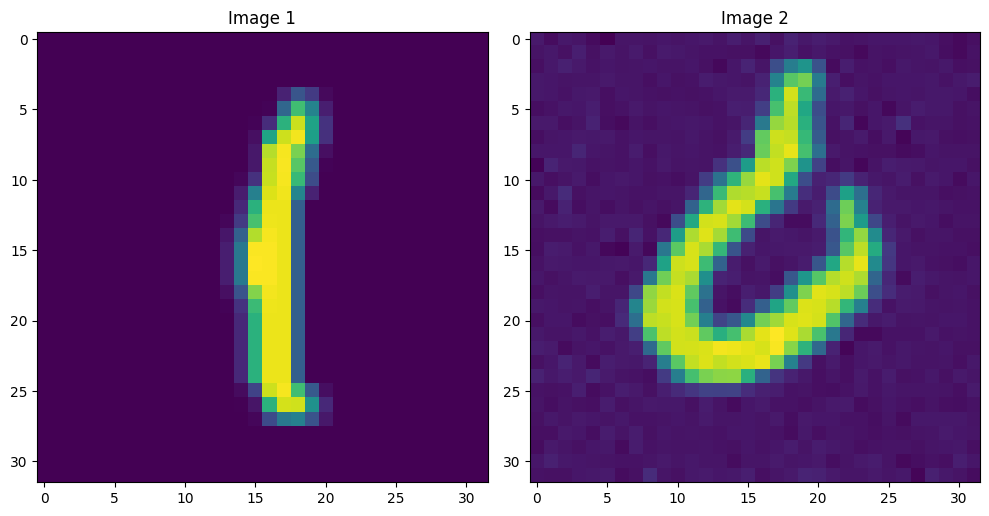

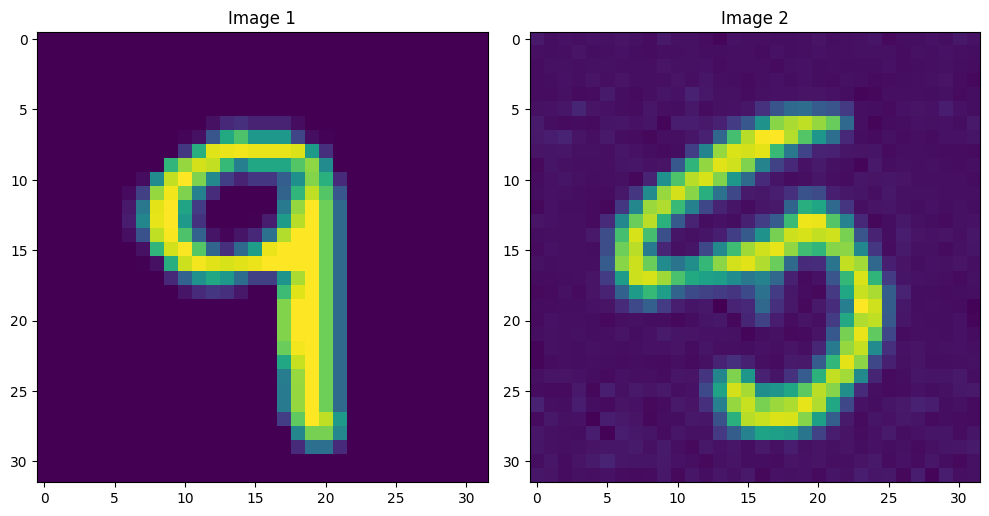

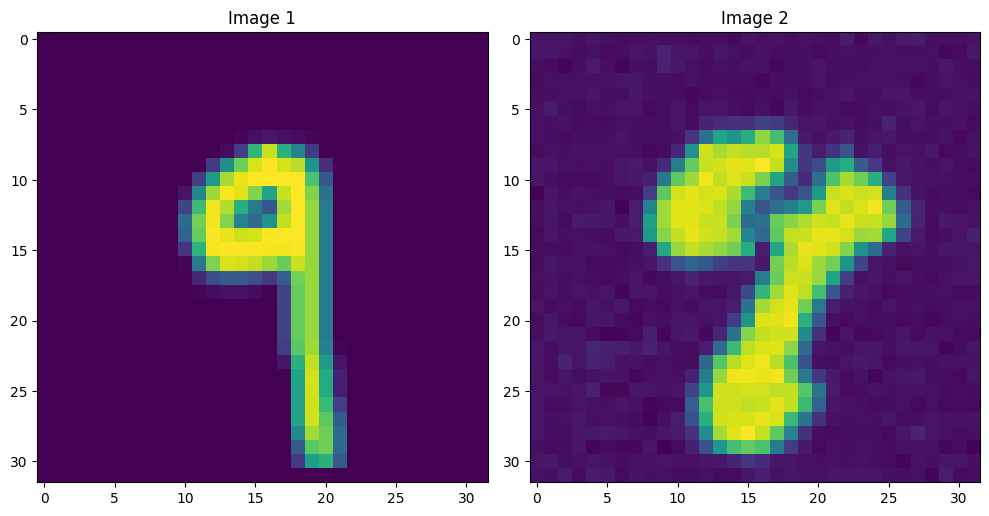

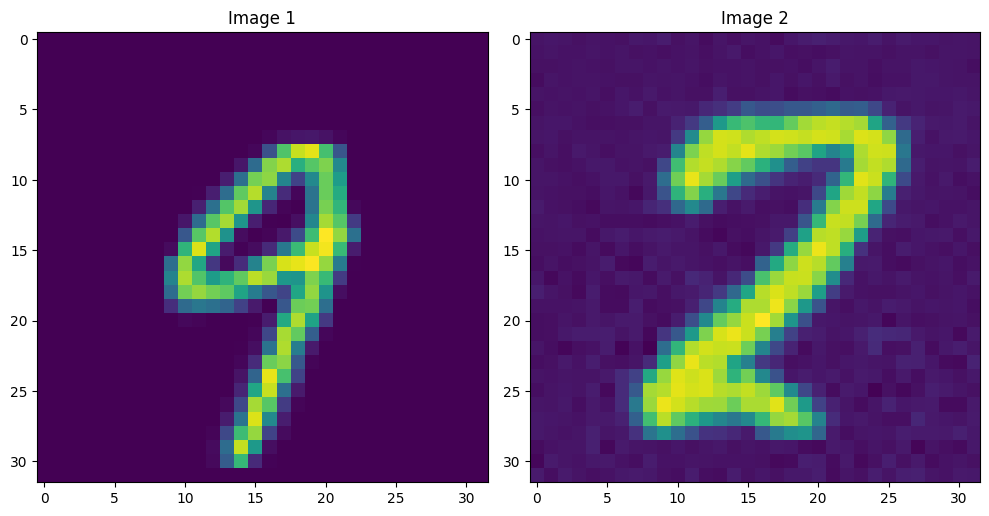

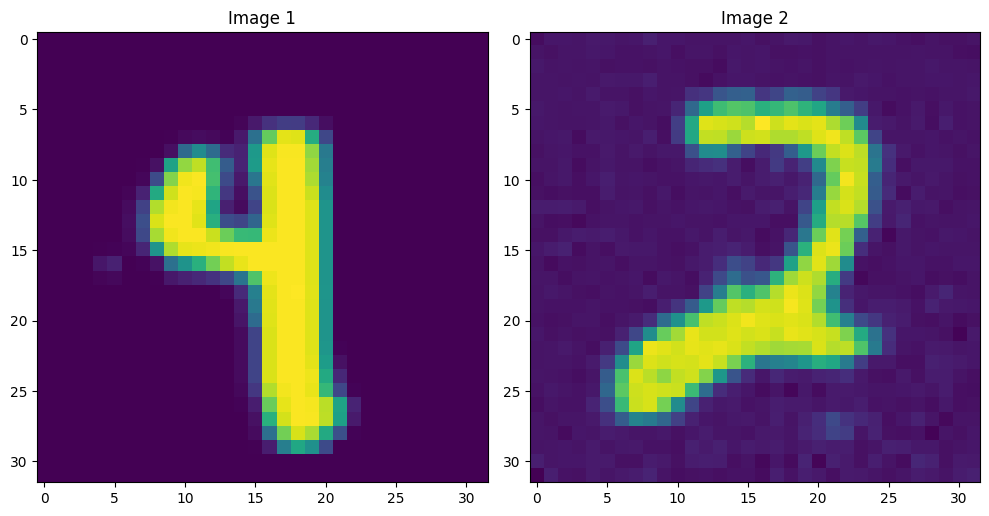

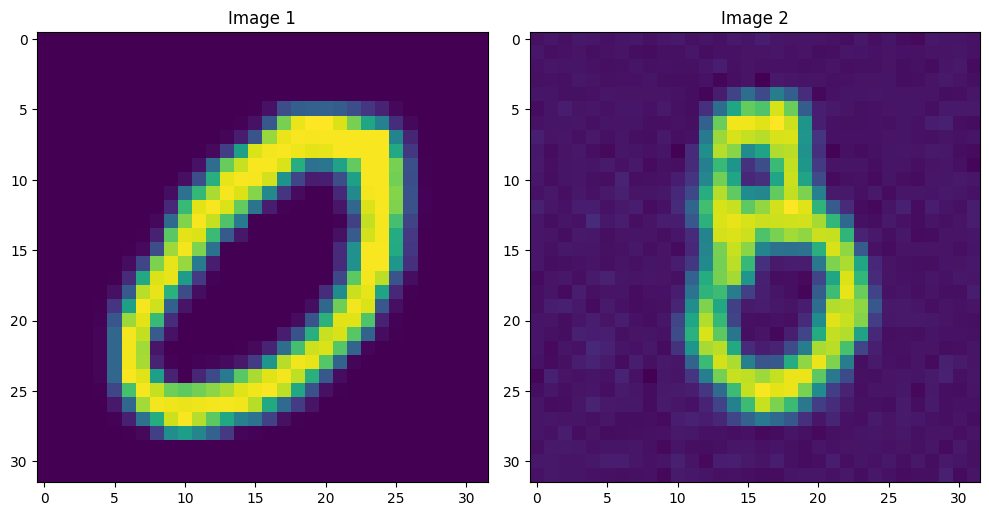

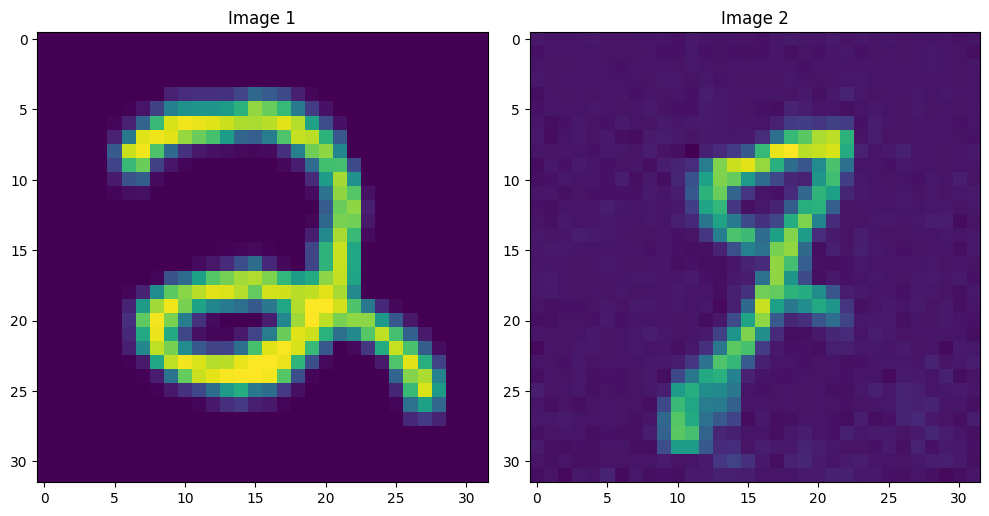

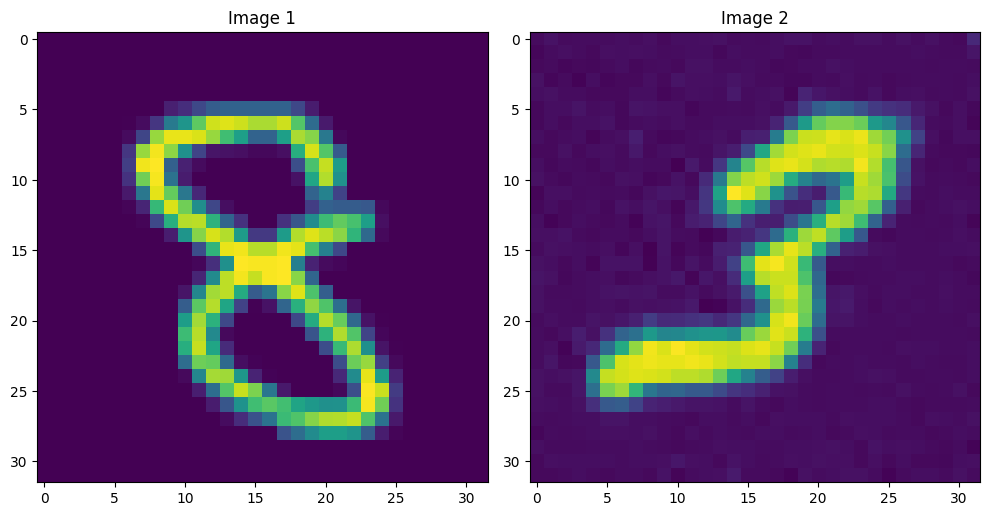

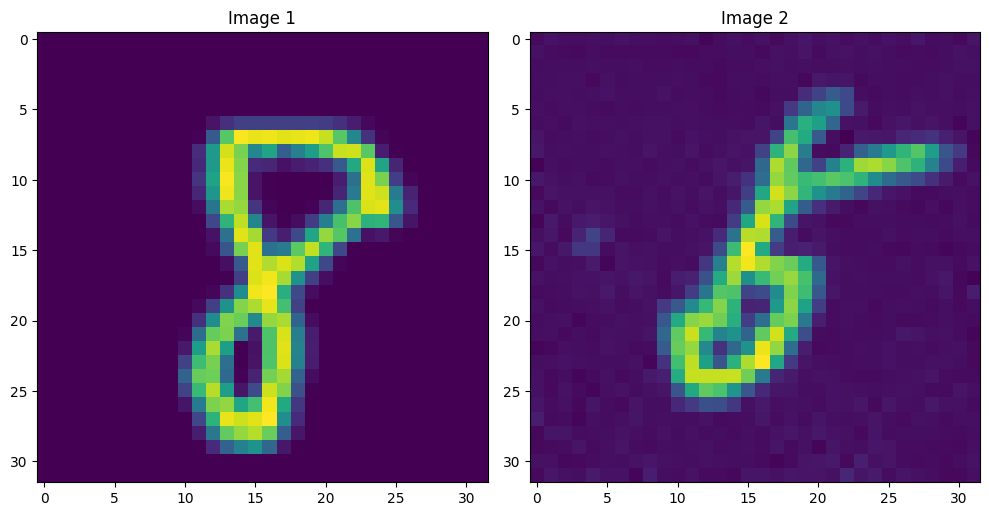

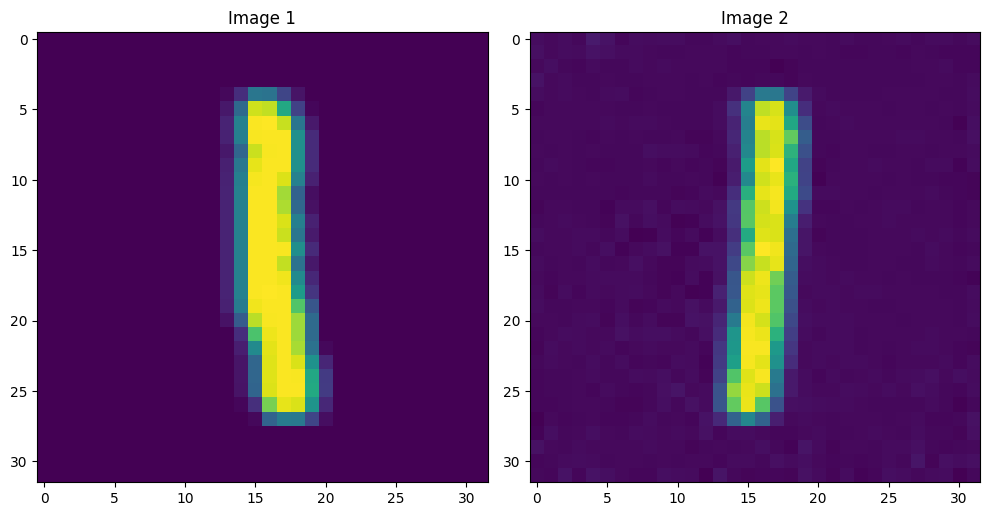

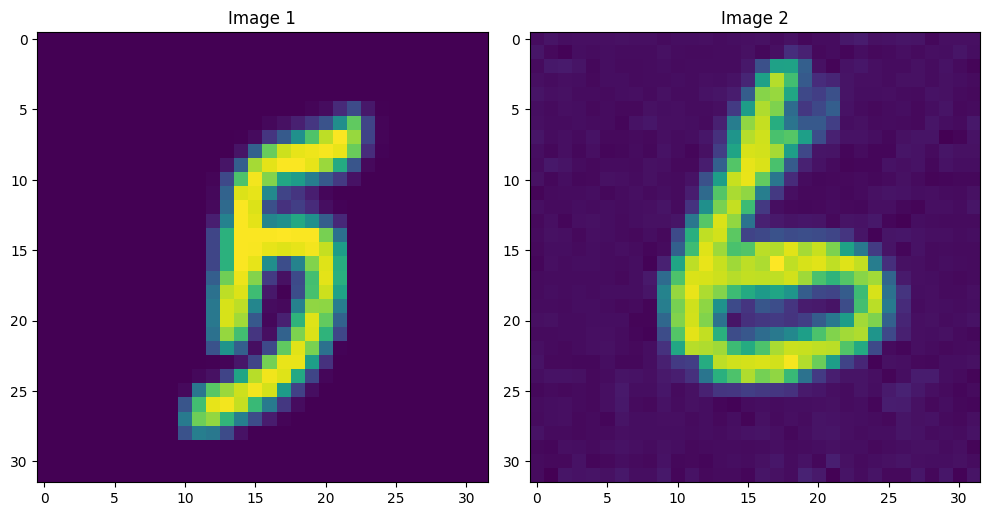

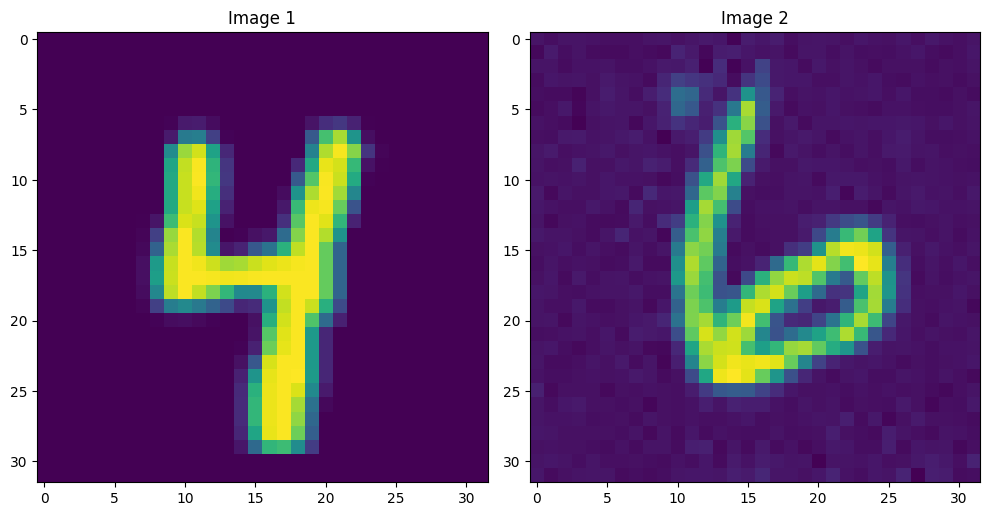

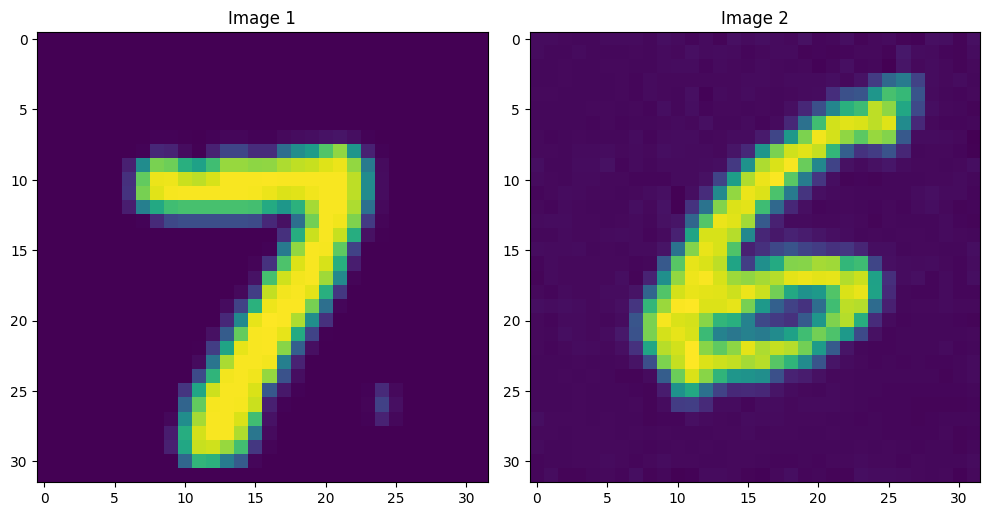

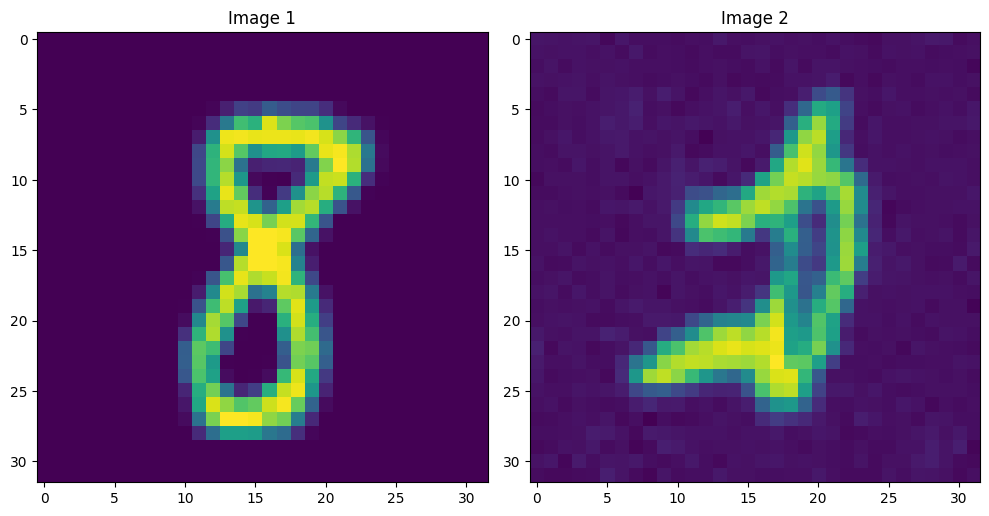

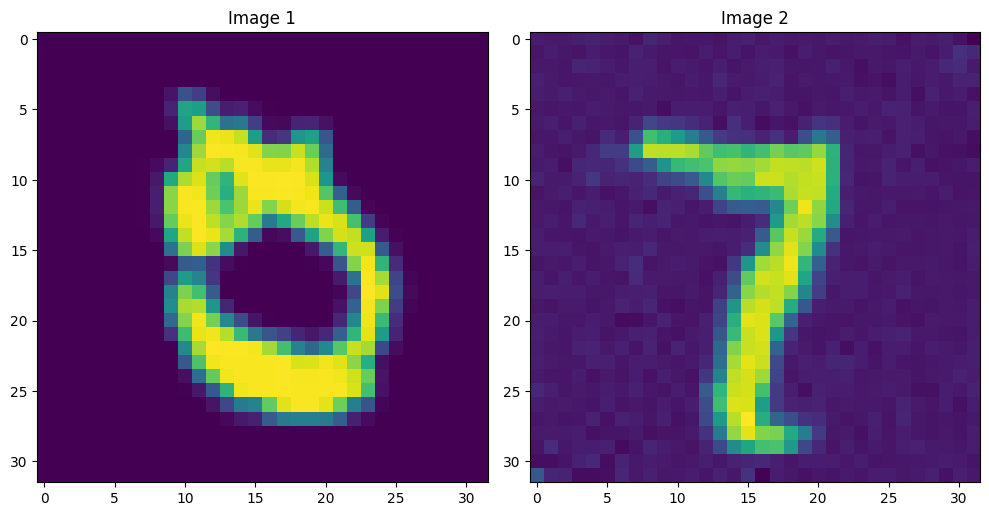

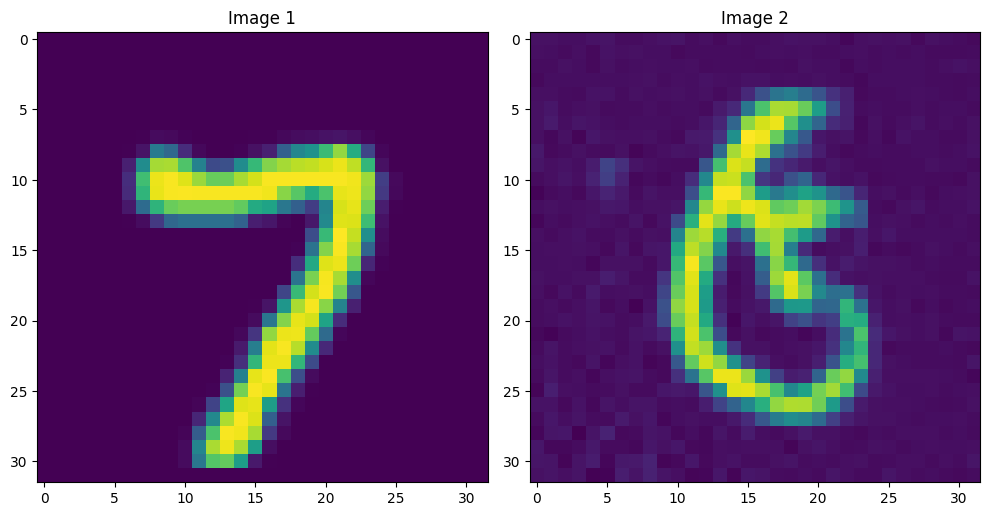

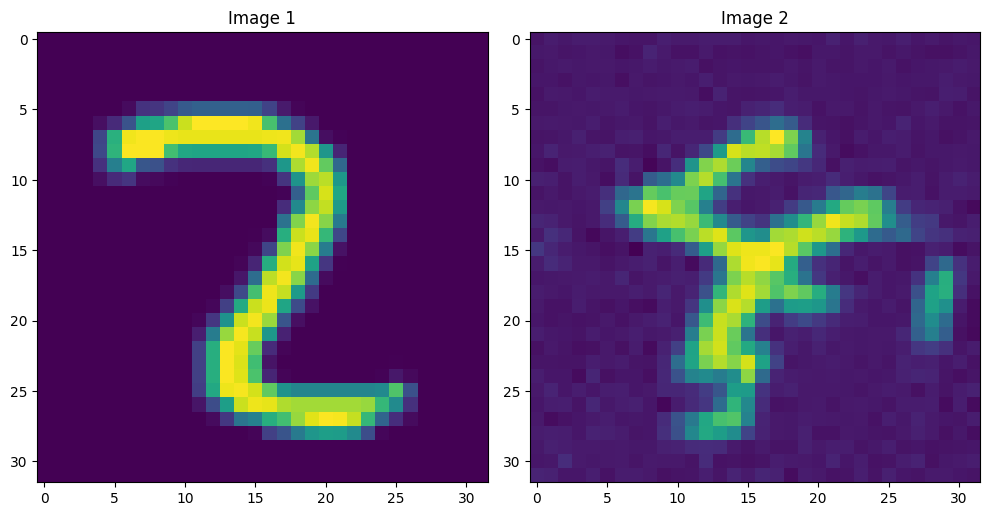

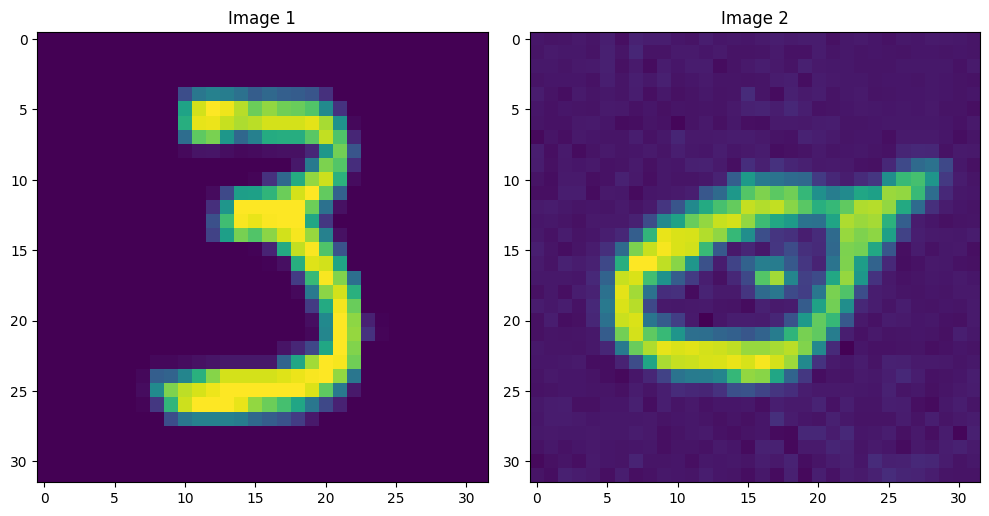

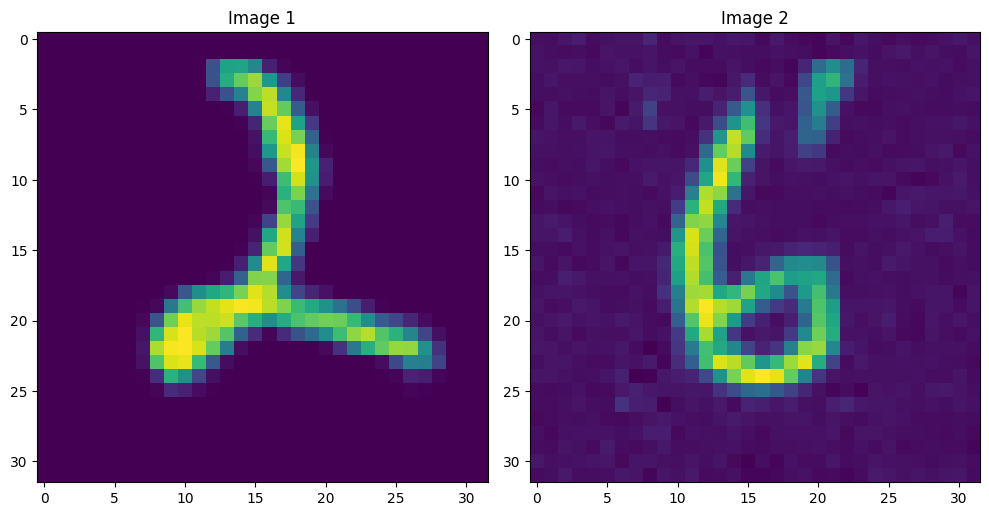

In [ ]:
print_result(result_DDIM)

# Evaluation

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification",
                model="farleyknight-org-username/vit-base-mnist",
                device=device)

def convert_to_pil(x):
    res = []
    for i in range(x.shape[0]):
        res.append(to_pil_image(x[i]))
    return res

def help(result):
    res = [0.00000001] * 10
    for r in result:
        res[int(r['label'])] = r['score']
    return res

def inception_model(inputs):
    # inputs : [B, 1, 32, 32]
    out = pipe(convert_to_pil(inputs))
    out = [help(x) for x in out]
    return out

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/985 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

In [ ]:
# Function to get inception features
def get_inception_features(dataloader, model, device):
    model.eval()
    features = []
    with torch.no_grad():
        for index, batch in enumerate(dataloader):
            batch = batch['image'].to(device)
            if batch.shape[1] == 1:  # Convert grayscale to RGB
                batch = batch.repeat(1, 3, 1, 1)
            print(batch.shape)
            preds = model(batch)[0].view(batch.size(0), -1)
            features.append(preds.cpu().numpy())
    return np.concatenate(features, axis=0)

# Calculate FID
def calculate_fid(real_features, fake_features):
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def calculate_inception_score(results):
    scores = []
    for part in results:
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([np.sum(p * np.log(p / py)) for p in part])))
    return np.mean(scores), np.std(scores)

def get_inception_score(result):
    classifier_result = []

    for image, noised_image, denoised_image in result:
        # denoised_image : [B, 1, 32, 32]
        classifier_result += inception_model(denoised_image)

    inception_score_mean, inception_score_std = calculate_inception_score(classifier_result)
    print(f'Inception Score: {inception_score_mean} ± {inception_score_std}')

In [ ]:
get_inception_score(result_DDPM)

Inception Score: 1.1976100982701894 ± 0.06744469197503798


In [ ]:
get_inception_score(result_DDIM)

Inception Score: 1.101032649419628 ± 0.03906343304629811
